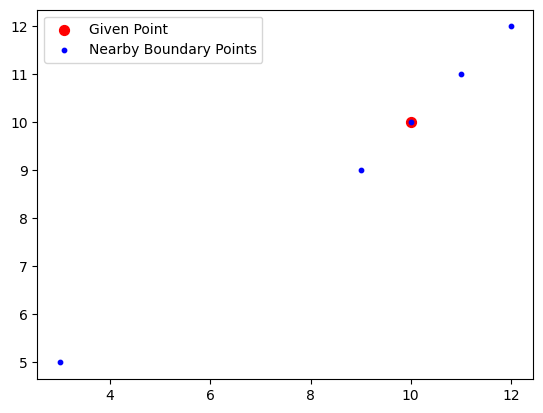

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_nearby_points(boundary_points, given_point, distance_threshold=10):
    """
    Plot boundary points that are within a specified distance from a given point.

    Args:
    - boundary_points: 2D array of boundary points
    - given_point: A point [x, y]
    - distance_threshold: Distance within which to select and plot boundary points
    """

    boundary_points_array = np.array(boundary_points)
    given_point_array = np.array(given_point)

    # Calculate Euclidean distance between the given point and each boundary point
    distances = np.linalg.norm(boundary_points_array - given_point_array, axis=1)

    # Select boundary points within the distance threshold
    nearby_points = boundary_points_array[distances < distance_threshold]

    # Plot the given point
    plt.scatter(given_point[0], given_point[1], color='red', s=50, label='Given Point')

    # Plot the nearby boundary points
    plt.scatter(nearby_points[:, 0], nearby_points[:, 1], color='blue', s=10, label='Nearby Boundary Points')

    plt.legend()
    plt.show()

# Example data
boundary_points = [[1, 1], [2, 3], [3, 5], [9, 9], [10, 10], [11, 11], [12, 12]]
given_point = [10, 10]

plot_nearby_points(boundary_points, given_point, distance_threshold=10)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Cosine Similarity between cropped edges of images
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from scipy.spatial.distance import cosine
from PIL import Image
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d


np.set_printoptions(precision=3)

(<matplotlib.image.AxesImage at 0x7efe5b0a5df0>, (224, 224, 3))

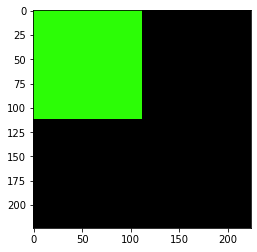

In [33]:
rectangle_img = np.zeros((1080, 1920))
rectangle_img[450:650, 800:1100] = 1
corners = [(450, 800), (450, 1100), (650, 800), (650, 1100)]

cols = np.random.rand(3)
for corner in corners:
    img_patch = rectangle_img[corner[0]-112:corner[0]+112, corner[1]-112:corner[1]+112]
    img_patch = np.dstack((img_patch, img_patch, img_patch))*cols
plt.imshow(img_patch), img_patch.shape

In [26]:
# Load the pretrained ResNet model
model = resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# Load an image of a rectangle
image = rectangle_img

# Define the corners' coordinates
corners = [(450, 800), (450, 1100), (650, 800), (650, 1100)]

# Preprocess the images and pass through the ResNet model
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

corner_features = []
with torch.no_grad():
    for corner in corners:
        # Crop the corner from the image
        corner_img = image[corner[0]-112:corner[0]+112, corner[1]-112:corner[1]+112]
        corner_img = np.dstack((corner_img*0.8, corner_img*1, corner_img*0.1))
        corner_img = Image.fromarray(np.uint8(corner_img*255))
        corner_img = transform(corner_img).unsqueeze(0)
        
        # Forward pass through ResNet
        corner_feature = model(corner_img)
        corner_features.append(corner_feature.squeeze())

# Compute cosine similarity scores
similarity_matrix = torch.zeros((4, 4))
for i in range(4):
    for j in range(4):
        similarity_matrix[i, j] = 1 - cosine(corner_features[i], corner_features[j])

print(similarity_matrix)

tensor([[1.0000, 0.9576, 0.9331, 0.9239],
        [0.9576, 1.0000, 0.9223, 0.9386],
        [0.9331, 0.9223, 1.0000, 0.9707],
        [0.9239, 0.9386, 0.9707, 1.0000]])


In [ ]:
def pixel_to_xy(points, origin_pixel, scale_factors):
    """
    Convert an array of 2D points from pixel space to 2D XY-space.

    Args:
    points (list of tuples): List of (x_pixel, y_pixel) pixel coordinates.
    origin_pixel (tuple): (x_origin, y_origin) pixel coordinates of the origin.
    scale_factors (tuple): (x_scale, y_scale) scale factors for X and Y axes.

    Returns:
    list of tuples: List of (x_xy, y_xy) XY-space coordinates.
    """
    xy_points = []
    for x_pixel, y_pixel in points:
        x_xy = (x_pixel - origin_pixel[0]) * scale_factors[0]
        y_xy = (origin_pixel[1] - y_pixel) * scale_factors[1]
        xy_points.append((x_xy, y_xy))
    return xy_points

    # Define pixel coordinates of points
pixel_points = [(100, 200), (150, 250), (200, 300)]

# Define origin and scale factors
origin_pixel = (50, 50)  # Example origin in pixel space
scale_factors = (0.1, 0.1)  # Example scale factors

# Convert to XY-space coordinates
xy_points = pixel_to_xy(pixel_points, origin_pixel, scale_factors)

# Print the resulting XY-space coordinates
print(xy_points)

In [ ]:
def get_nearest_robot_and_crop(self, env_idx):
        # plt.figure(figsize=(6.6667,11.85))
        img = self.current_scene_frame['color'].data.astype(np.uint8)
        # plt.imshow(img)
        # plt.show()
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, self.lower_green_filter, self.upper_green_filter)
        seg_map = cv2.bitwise_and(img, img, mask = mask)
        seg_map = cv2.cvtColor(seg_map, cv2.COLOR_BGR2GRAY)

        boundary = cv2.Canny(seg_map,100,200)
        boundary_pts = np.array(np.where(boundary==255)).T
        # 0, 1920 are origin pixels in img space
        boundary_pts[:,0] = (boundary_pts[:,0] - 0)/1080*(self.plane_size[1][0]-self.plane_size[0][0])+self.plane_size[0][0]
        boundary_pts[:,1] = (1920 - boundary_pts[:,1])/1920*(self.plane_size[1][1]-self.plane_size[0][1])+self.plane_size[0][1]
        
        # plt.scatter(boundary_pts[:,0], boundary_pts[:,1], c='b')
        # plt.scatter(self.nn_helper.kdtree_positions[:,0], self.nn_helper.kdtree_positions[:,1], c='r')
        # plt.show()
        com = np.mean(boundary_pts, axis=0)

        if len(boundary_pts) > 200:
            self.bd_pts[env_idx] = boundary_pts[np.random.choice(range(len(boundary_pts)), size=200, replace=False)]
        else:
            self.bd_pts[env_idx] = boundary_pts
        idxs, neg_idxs = self.nn_helper.get_nn_robots(self.bd_pts[env_idx])
        idxs = np.array(list(idxs))
        min_idx = tuple(idxs[np.lexsort((idxs[:, 0], idxs[:, 1]))][0])
        
        """ Single Robot Experiment. Change this to include entire neighborhood """
        self.active_idxs[env_idx] = {min_idx: np.array((0,0))} # Store the action vector as value here later :)
        # [self.active_idxs[idx]=np.array((0,0)) for idx in idxs]

        idxs = np.array(list(idxs))
        neighbors = self.nn_helper.robot_positions[idxs[:,0], idxs[:,1]]

        finger_pos = self.nn_helper.robot_positions[min_idx].copy()
        finger_pos[0] = (finger_pos[0] - self.plane_size[0][0])/(self.plane_size[1][0]-self.plane_size[0][0])*1080 - 0
        finger_pos[1] = 1920 - (finger_pos[1] - self.plane_size[0][1])/(self.plane_size[1][1]-self.plane_size[0][1])*1920
        finger_pos = finger_pos.astype(np.int32)

        # plt.imshow(seg_map)
        # for i in range(8):
        #     for j in range(8):
        #         finger_pos = self.nn_helper.robot_positions[i,j].copy()
        #         finger_pos[0] = (finger_pos[0] - self.plane_size[0][0])/(self.plane_size[1][0]-self.plane_size[0][0])*1080 - 0
        #         finger_pos[1] = 1920 - (finger_pos[1] - self.plane_size[0][1])/(self.plane_size[1][1]-self.plane_size[0][1])*1920
        #         finger_pos = finger_pos.astype(np.int32)

        #         plt.scatter(finger_pos[1], finger_pos[0], c='r')        
        # plt.show()

        crop = seg_map[finger_pos[0]-224:finger_pos[0]+224, finger_pos[1]-224:finger_pos[1]+224]
        crop = cv2.resize(crop, (224,224), interpolation=cv2.INTER_AREA)
        # plt.imshow(crop)
        # plt.show()
        cols = np.random.rand(3)
        crop = np.dstack((crop, crop, crop))*cols
        crop = Image.fromarray(np.uint8(crop*255))
        crop = self.transform(crop).unsqueeze(0).to(device)
        with torch.no_grad():
            state = self.model(crop)
        return state.detach().cpu().squeeze()

In [3]:
# plane_size = 1000*np.array([(0.132-0.025, -0.179-0.055),(0.132+0.025, -0.179+0.055)])


finger_positions = np.zeros((8,8,2))
kdtree_positions = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2==0:
            finger_positions[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
            kdtree_positions[i*8 + j, :] = (i*0.0375, j*0.043301 - 0.02165)
        else:
            finger_positions[i, j] = np.array((i*0.0375, j*0.043301))
            kdtree_positions[i*8 + j, :] = (i*0.0375, j*0.043301)

min_x = np.min(finger_positions[:,:,0])
max_x = np.max(finger_positions[:,:,0])
min_y = np.min(finger_positions[:,:,1])
max_y = np.max(finger_positions[:,:,1])
min_x, min_y, max_x, max_y, (max_x+min_x)/2, (max_y+min_y)/2

(0.0, -0.02165, 0.2625, 0.303107, 0.13125, 0.1407285)

/home/nagababa/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


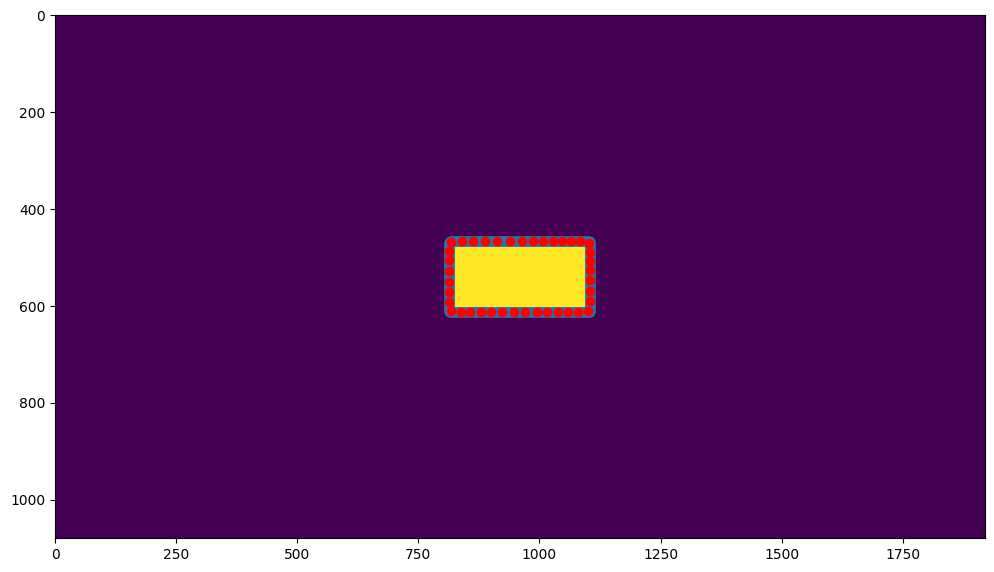

In [16]:
seg_map = cv2.imread('./data/testing/boundary.png', 0)

boundary = cv2.Canny(seg_map,100,200)
boundary_pts = np.array(np.where(boundary==255)).T

kmeans = KMeans(n_clusters=40, random_state=0).fit(boundary_pts)
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(12,15))
plt.imshow(seg_map)
plt.scatter(boundary_pts[:,1], boundary_pts[:,0])
plt.scatter(cluster_centers[:,1], cluster_centers[:,0], c='r')

[[ 9.963e-01 -8.617e-02  0.000e+00  1.152e+02]
 [ 8.617e-02  9.963e-01  0.000e+00  5.757e+01]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


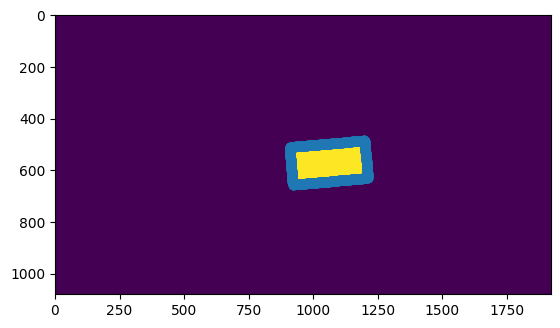

In [31]:
from utils.geometric_utils import icp


angle = 5
tx, ty = 100, 30

height, width = seg_map.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
rotated_seg_map = cv2.warpAffine(seg_map, rotation_matrix, (width, height))
translated_seg_map = cv2.warpAffine(rotated_seg_map, translation_matrix, (width, height))
mask = translated_seg_map == 0

translated_seg_map[mask] = 0
boundary = cv2.Canny(translated_seg_map,100,200)
boundary_pts2 = np.array(np.where(boundary==255)).T
np.random.shuffle(boundary_pts2)

M = icp(boundary_pts, boundary_pts2, icp_radius=1000)
theta = np.arctan2(M[1, 0], M[0, 0])
# theta = np.linalg.norm(theta_radians)
theta_degrees = np.rad2deg(theta)
M[0,3], M[1,3],theta, theta_degrees
print(M)


plt.imshow(translated_seg_map)
plt.scatter(boundary_pts2[:,1], boundary_pts2[:,0])

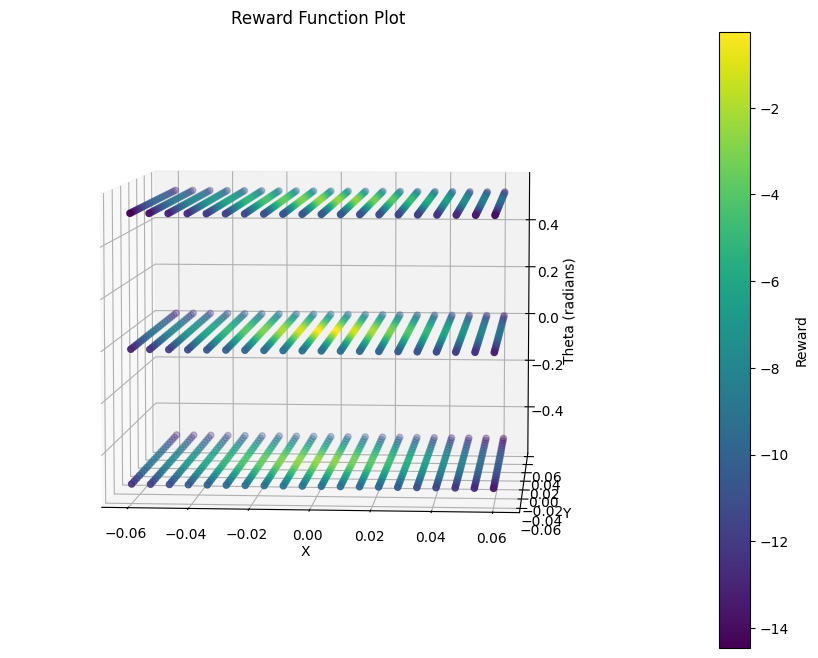

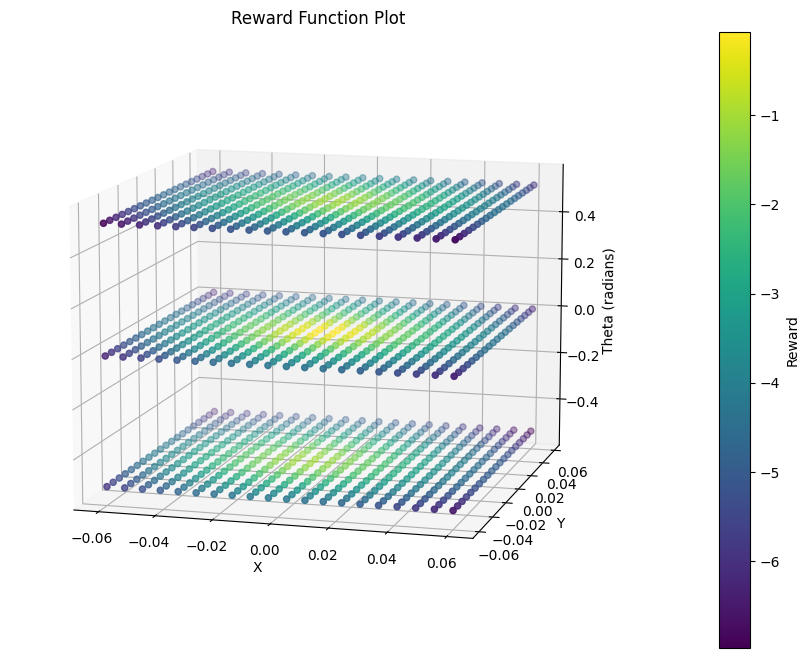

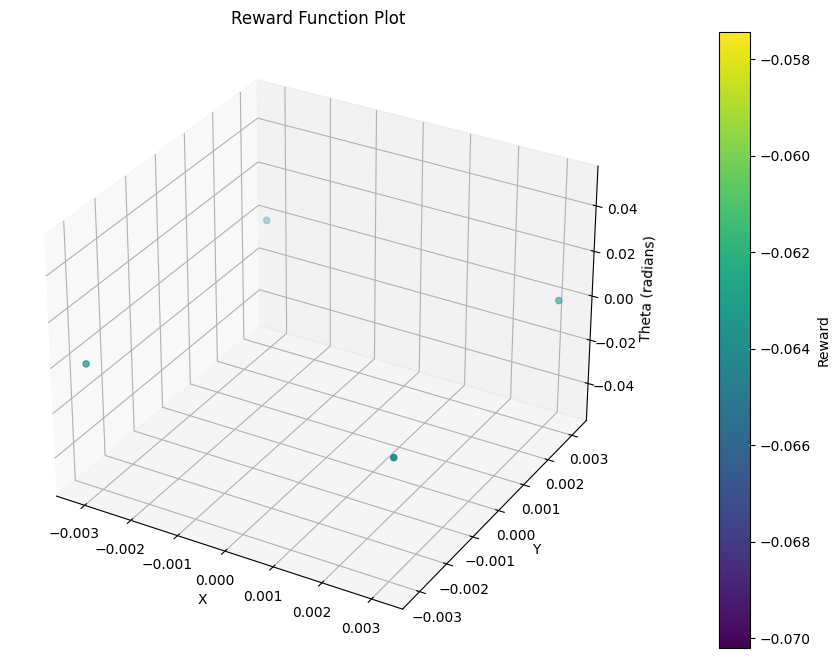

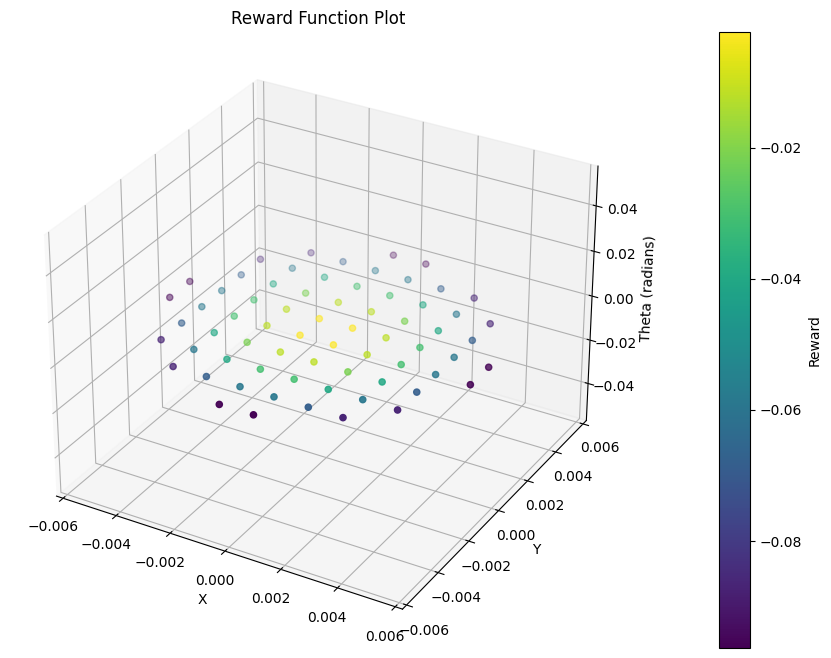

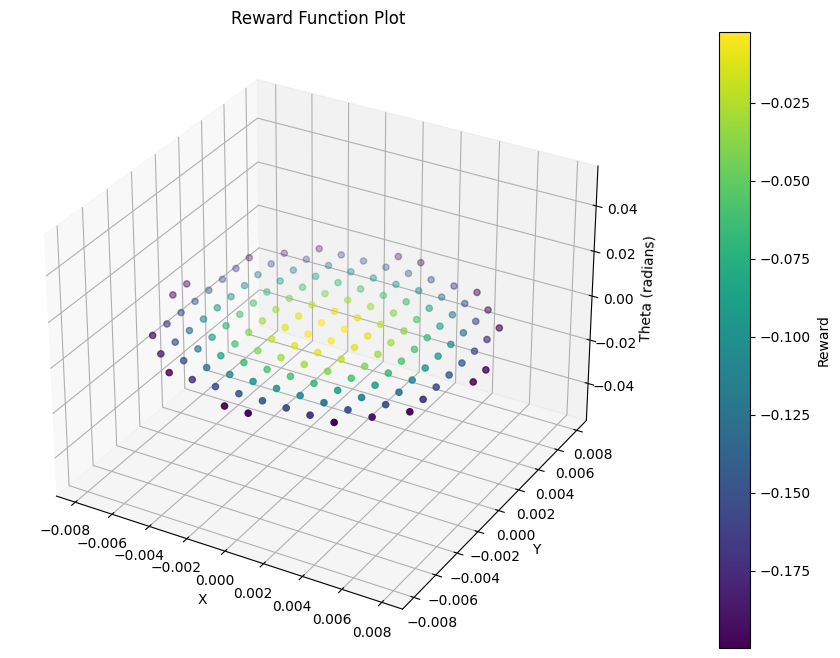

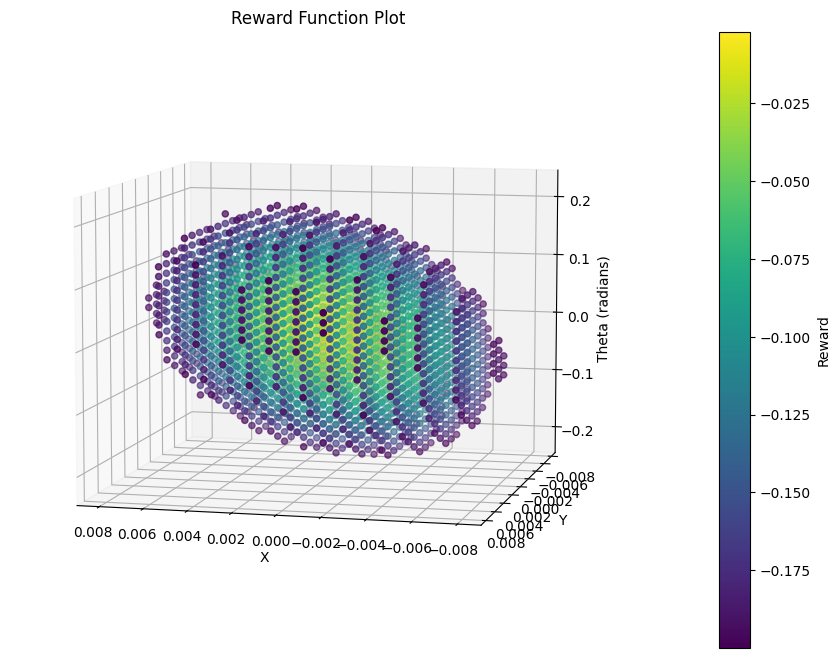

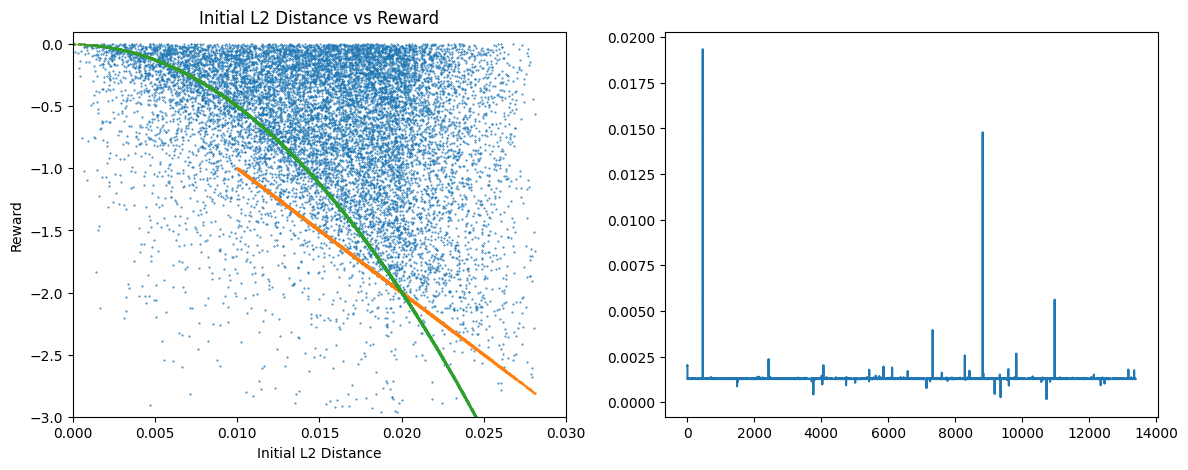

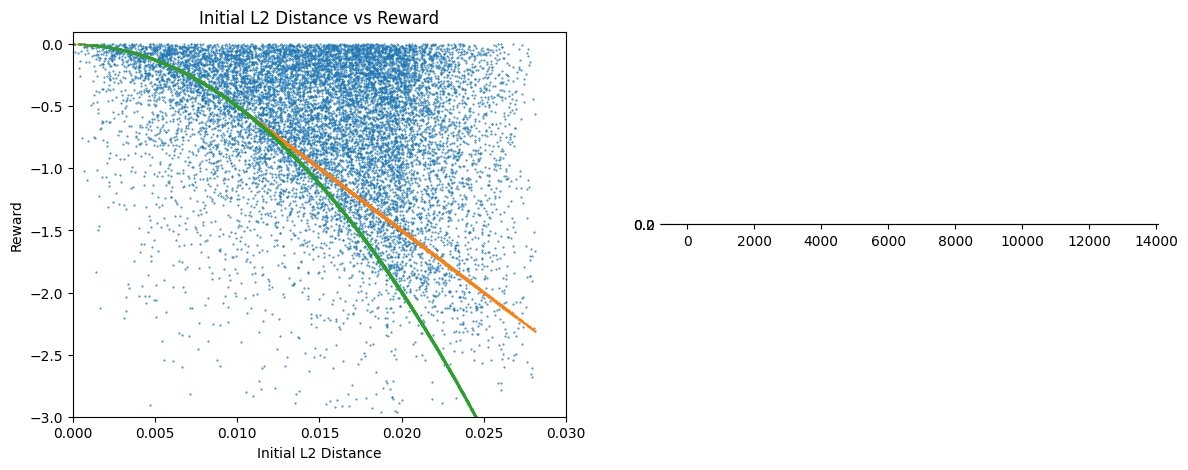

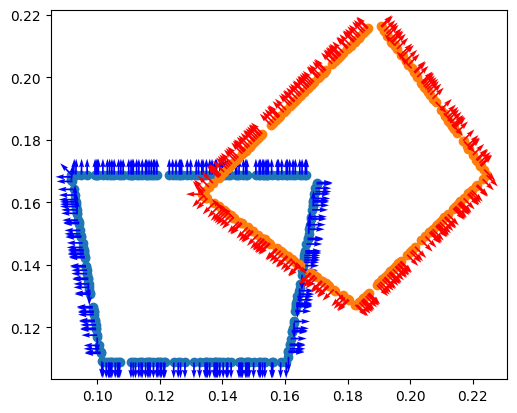

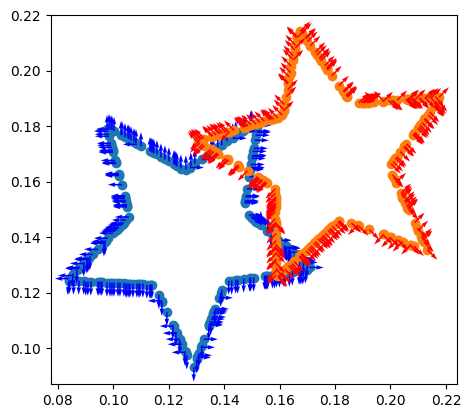

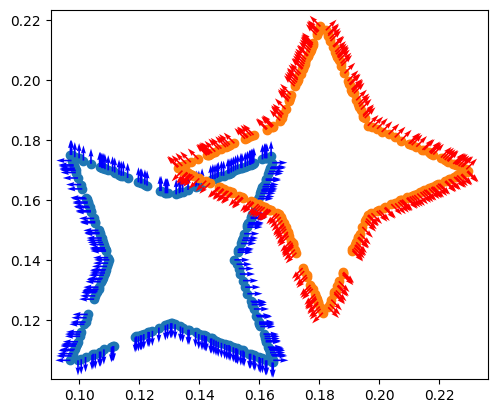

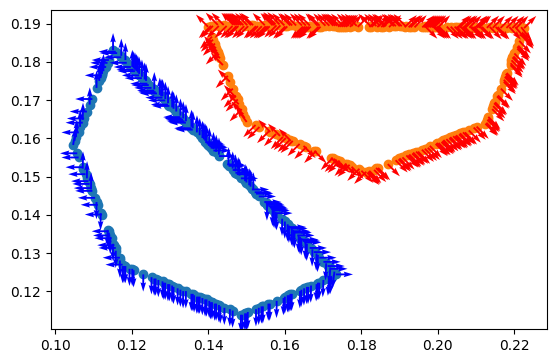

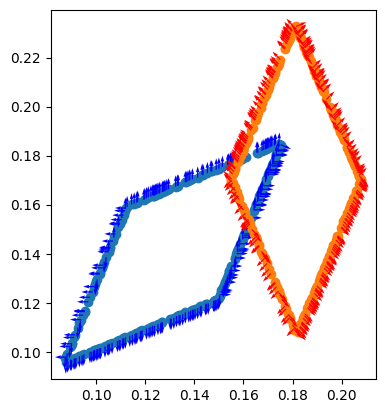

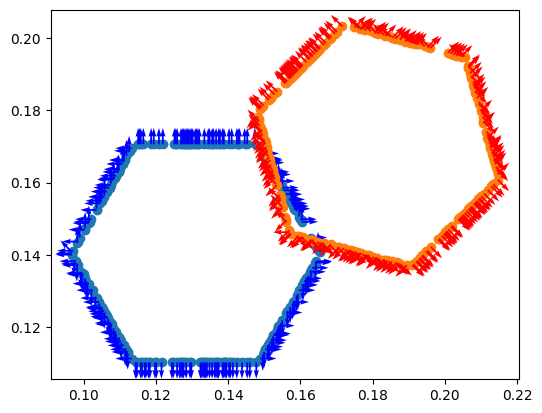

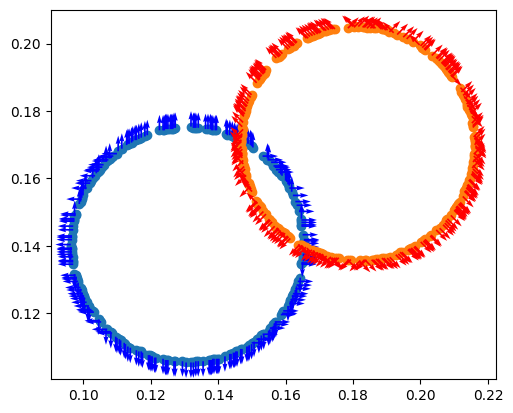

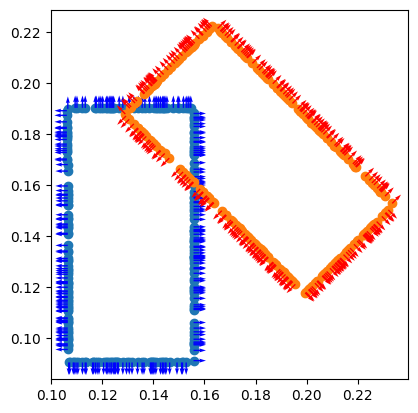

In [16]:
%matplotlib inline
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

def compute_normal(p1, p2):
    d = np.array([p2[0] - p1[0], p2[1] - p1[1]])
    normal = np.array([d[1], -d[0]])
    norm = np.linalg.norm(normal)
    if norm == 0:
        return (0, 0)  # Avoid division by zero
    return normal / norm

def normalize_angle(theta):
    """Normalize the angle to be within the range [-pi, pi]."""
    return (theta + np.pi) % (2 * np.pi) - np.pi

def compute_transformation(points, normals, initial_pose, final_pose):
    """Compute the transformed points and normals given initial and final poses."""
    x0, y0, theta0 = initial_pose
    x1, y1, theta1 = final_pose
    translation = np.array([x1 - x0, y1 - y0])
    delta_theta = normalize_angle(theta1 - theta0)

    rotation_matrix = np.array([
        [np.cos(delta_theta), -np.sin(delta_theta)],
        [np.sin(delta_theta), np.cos(delta_theta)]
    ])

    rotated_points = np.dot(points - np.array([x0, y0]), rotation_matrix.T) + np.array([x1, y1])
    rotated_normals = np.dot(normals, rotation_matrix.T)
    return rotated_points, rotated_normals

bd_pts_dict = pkl.load(open('./config/assets/obj_props.pkl', 'rb'))
for name in bd_pts_dict.keys():
    _, boundary_points, normals, initial_pose = bd_pts_dict[name]

    final_pose = (0.18125, 0.1707285, np.deg2rad(45))   # (x1, y1, theta1)

    transformed_points, transformed_normals = compute_transformation(boundary_points, normals, initial_pose, final_pose)
    plt.scatter(boundary_points[:, 0], boundary_points[:, 1], label='Initial Points')
    plt.quiver(boundary_points[:, 0], boundary_points[:, 1], normals[:, 0], normals[:, 1], color='blue', label='Initial Normals')
    plt.scatter(transformed_points[:, 0], transformed_points[:, 1], label='Transformed Points')
    plt.quiver(transformed_points[:, 0], transformed_points[:, 1], transformed_normals[:, 0], transformed_normals[:, 1], color='red', label='Transformed Normals')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
%matplotlib widget
x_values = np.linspace(-0.06, 0.06, 100)  # 10 steps for x
y_values = np.linspace(-0.06, 0.06, 100)  # 10 steps for y
theta_values = np.linspace(np.deg2rad(-45), np.deg2rad(45), 100)
# theta_values = np.deg2rad(np.array([-30, 0, 30]))

def reward_function(goal, final):
    loss = 5 * np.linalg.norm(goal - final)
    if loss < 1:
        loss = -0.5  * loss**2
    else:
        loss = -loss + 0.5
    return loss

for name in list(bd_pts_dict.keys())[:1]:
    _, boundary_points, normals, initial_pose = bd_pts_dict[name]
    rewards = []
    for x in x_values:
        for y in y_values:
            for theta in theta_values:
                final_pose = (initial_pose[0] + x, initial_pose[1] + y, initial_pose[2] + theta)
                transformed_points, transformed_normals = compute_transformation(boundary_points, normals, initial_pose, final_pose)
                reward = reward_function(boundary_points, transformed_points)
                rewards.append((x, y, theta, reward))
    rewards = np.array(rewards)

    #keep only those rewards that are <=15
    rewards = rewards[abs(rewards[:,3]) <= 0.2]

    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of rewards
    sc = ax.scatter(rewards[:, 0], rewards[:, 1], rewards[:, 2], c=rewards[:, 3], cmap='viridis', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Theta (radians)')
    ax.set_title('Reward Function Plot')

    # Add color bar
    cb = plt.colorbar(sc, ax=ax, pad=0.1)
    cb.set_label('Reward')

    plt.show()
    

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

replay_buffer = pkl.load(open('./replay_buffer.pkl', 'rb'))
replay_buffer.keys()

dict_keys(['obs', 'obs2', 'act', 'pos', 'rew', 'done', 'num_agents', 'obj_names'])

In [186]:
np.unique(replay_buffer['obj_names'])

TypeError: '<' not supported between instances of 'NoneType' and 'str'

(-4.0, 0.1)

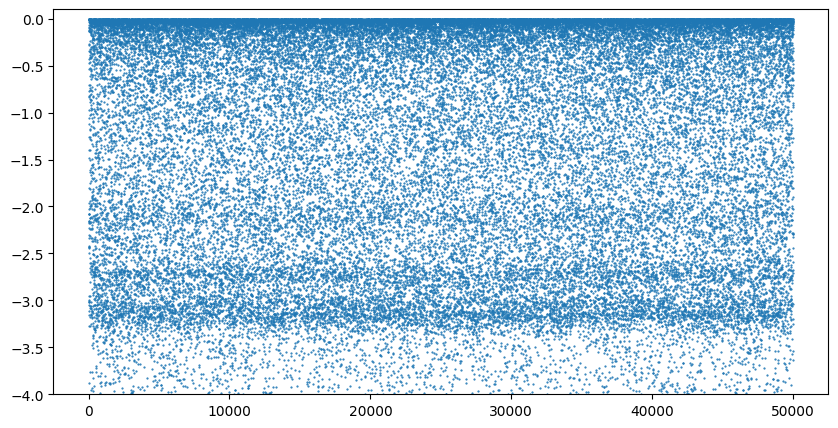

In [187]:
s0 = replay_buffer['obs'][0]
s1 = replay_buffer['obs2'][0]
a = replay_buffer['act'][0]
pos = replay_buffer['pos'][0]

plt.figure(figsize=(10,5))
plt.scatter(range(len(replay_buffer['rew'][:50000])),replay_buffer['rew'][:50000], s=0.3)
plt.ylim(-4,0.1)

In [31]:
rb_pos_pix = np.zeros((8,8,2))
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_pix = np.zeros((64, 2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if real_or_sim=="real":
            if i%2!=0:
                finger_pos = np.array((i*3.75, -j*4.3301 + 2.165))
            else:
                finger_pos = np.array((i*3.75, -j*4.3301))
        else:
            if i%2!=0:
                finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
                rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
            else:
                finger_pos = np.array((i*0.0375, j*0.043301))
                rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]
        
        finger_pos[0] = (finger_pos[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0
        finger_pos[1] = 1920 - (finger_pos[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920
        # finger_pos = finger_pos.astype(np.int32)
        rb_pos_pix[i,j] = finger_pos
        kdtree_positions_pix[i*8 + j, :] = rb_pos_pix[i,j]



r_poses = rb_pos_world[tuple(zip(*active_idxs[env_idx]))]
init_pts = init_state[env_idx, :n_idxs[env_idx], :2].copy()
goal_bd_pts = init_state[env_idx, :n_idxs[env_idx], 2:4].copy()
final_bd_pts = final_state[env_idx, :n_idxs[env_idx], :2].copy()
act_grsp = actions_grasp[env_idx, :n_idxs[env_idx]].copy()
acts = actions[env_idx, :n_idxs[env_idx]].copy()
plt.figure(figsize=(10,17.78))
plt.scatter(r_poses[:, 0], r_poses[:, 1], c='#880000ff')
plt.scatter(goal_bd_pts[env_idx][:, 0], goal_bd_pts[env_idx][:, 1], c='#ffa50066')
plt.scatter(init_bd_pts[:, 0], init_bd_pts[:, 1], c = '#00ff0066')
plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')
plt.scatter(final_bd_pts[:, 0], final_bd_pts[:, 1], c='blue')
plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], scale=0.5, scale_units='xy')
plt.quiver(init_pts[:, 0], init_pts[:, 1], acts[:, 0], acts[:, 1], scale=1, scale_units='xy')
plt.gca().set_aspect('equal')
plt.show()

NameError: name 'real_or_sim' is not defined

In [5]:
import pickle as pkl

rewards = pkl.load(open('./data/rl_data/rl_data.pkl', 'rb'))

# Define the smoothing factor (0.9 in this example)
smoothing_factor = 0.99

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rewards[0]]
for r in rewards[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards, label='Smoothed Rewards', color='red', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Plot with 0.9 Smoothing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './data/rl_data/rl_data.pkl'

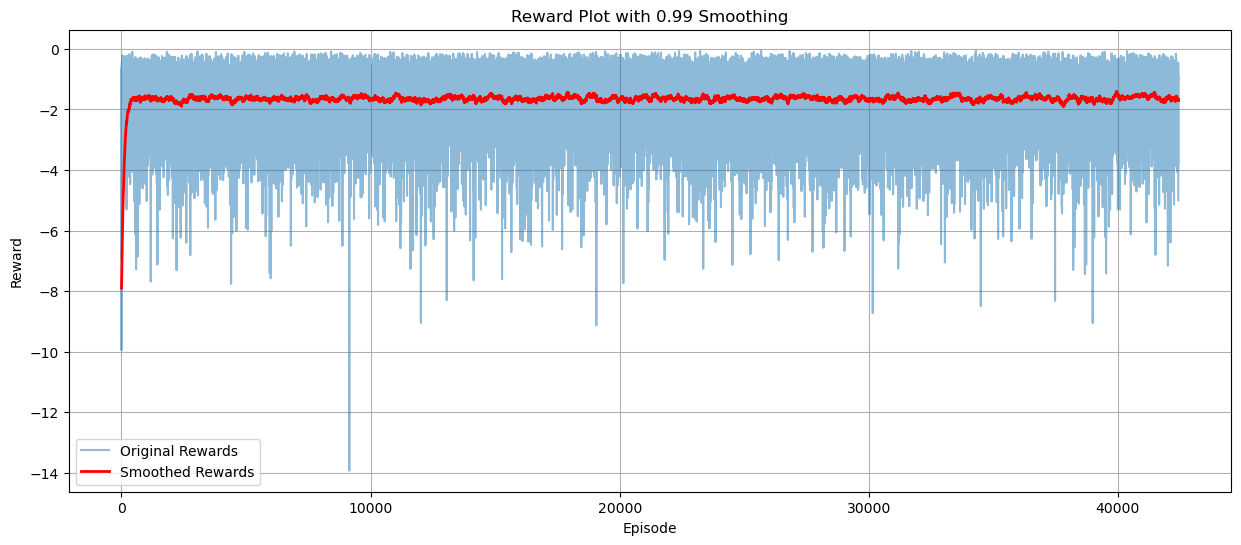

In [1]:
%matplotlib inline
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# with open('./data/rl_data/ddpg_expt_0/ddpg_expt_0_s69420/progress.txt', 'r') as f:
# with open('./data/rl_data/backup/sac_expt_grasp/progress.txt', 'r') as f:
# with open('./data/rl_data/masac_expt_0/masac_expt_0_s69420/progress.txt', 'r') as f:
with open('./data/rl_data/matsac_expt_0/matsac_expt_0_s69420/progress.txt', 'r') as f:
    lines = f.readlines()
    rewards = [float(line.split('\t')[1]) for line in lines[1:]]

rewards = np.array(rewards)

# Define the smoothing factor (0.9 in this example)
smoothing_factor = 0.99

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rewards[0]]
for r in rewards[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(15, 6))
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards, label='Smoothed Rewards', color='red', linewidth=2)
# plt.ylim(-200, 0)
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.title(f'Reward Plot with {smoothing_factor} Smoothing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

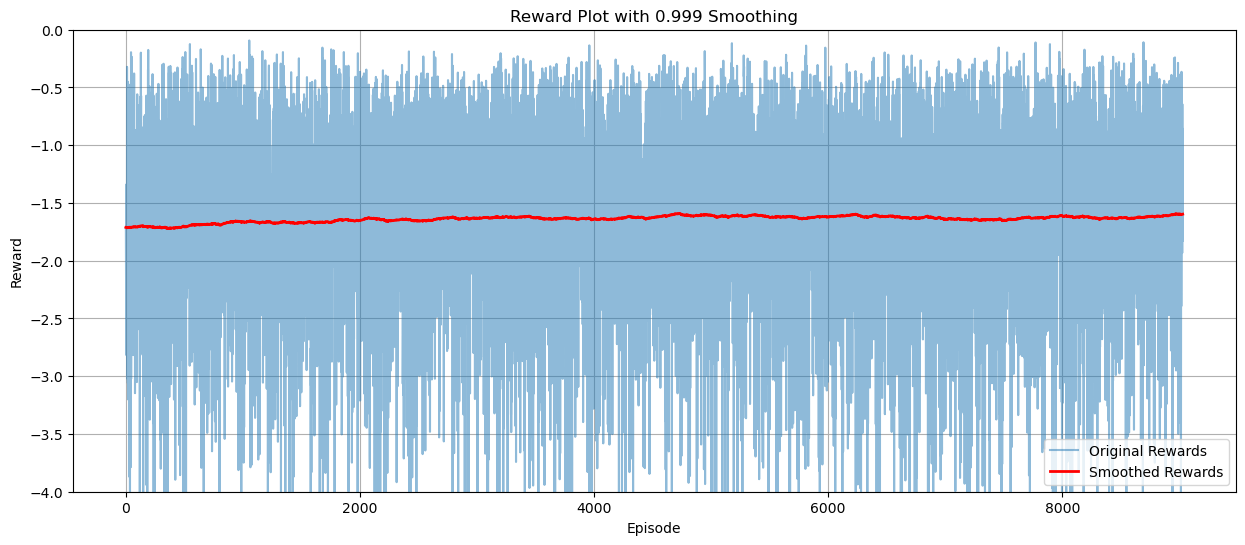

In [23]:
%matplotlib inline
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# with open('./data/rl_data/ddpg_expt_0/ddpg_expt_0_s69420/progress.txt', 'r') as f:
# with open('./data/rl_data/backup/sac_expt_grasp/progress.txt', 'r') as f:
# with open('./data/rl_data/masac_expt_0/masac_expt_0_s69420/progress.txt', 'r') as f:
with open('./data/rl_data/matsac_expt_1/matsac_expt_1_s69420/progress.txt', 'r') as f:
    lines = f.readlines()
    rewards = [float(line.split('\t')[1]) for line in lines[1:]]

rewards = np.array(rewards)

# Define the smoothing factor (0.9 in this example)
smoothing_factor = 0.999

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rewards[0]]
for r in rewards[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(15, 6))
plt.plot(rewards, label='Original Rewards', alpha=0.5)
plt.plot(smoothed_rewards, label='Smoothed Rewards', color='red', linewidth=2)
plt.ylim(-4, 0)
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.title(f'Reward Plot with {smoothing_factor} Smoothing')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [12]:

temp = ''.join(lines)
with open('./data/legacy/ddpg_expt_500iters_normalized.txt', 'w') as new_f:
    new_f.write(temp)

In [1]:
import numpy as np
plane_size = 1000*np.array([(0 - 0.063, 0 - 0.2095), (0.2625 + 0.063, 0.303107 + 0.1865)])
delta_plane_x = plane_size[1][0] - plane_size[0][0]
delta_plane_y = plane_size[1][1] - plane_size[0][1]
rad = 150
pix_rad =(rad - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080
pix_rad

592.1235521235521

In [3]:
robot_positions = np.zeros((8,8,2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*37.5, j*43.301 - 21.65))
        else:
            finger_pos = np.array((i*37.5, j*43.301))

        finger_pos[0] = (finger_pos[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0
        finger_pos[1] = 1920 - (finger_pos[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920
        finger_pos = finger_pos.astype(np.int32)
        robot_positions[i,j] = finger_pos

robot_positions

array([[[ 175., 1344.],
        [ 175., 1225.],
        [ 175., 1106.],
        [ 175.,  987.],
        [ 175.,  868.],
        [ 175.,  750.],
        [ 175.,  631.],
        [ 175.,  512.]],

       [[ 279., 1404.],
        [ 279., 1285.],
        [ 279., 1166.],
        [ 279., 1047.],
        [ 279.,  928.],
        [ 279.,  809.],
        [ 279.,  690.],
        [ 279.,  571.]],

       [[ 383., 1344.],
        [ 383., 1225.],
        [ 383., 1106.],
        [ 383.,  987.],
        [ 383.,  868.],
        [ 383.,  750.],
        [ 383.,  631.],
        [ 383.,  512.]],

       [[ 487., 1404.],
        [ 487., 1285.],
        [ 487., 1166.],
        [ 487., 1047.],
        [ 487.,  928.],
        [ 487.,  809.],
        [ 487.,  690.],
        [ 487.,  571.]],

       [[ 592., 1344.],
        [ 592., 1225.],
        [ 592., 1106.],
        [ 592.,  987.],
        [ 592.,  868.],
        [ 592.,  750.],
        [ 592.,  631.],
        [ 592.,  512.]],

       [[ 696., 1404.],
      

In [4]:
var = np.array([50, 50])
pix1 = np.array([(var[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0, 1920 - (var[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920])
var = np.array([150, 100])
pix2 = np.array([(var[0] - plane_size[0][0])/(plane_size[1][0]-plane_size[0][0])*1080 - 0, 1920 - (var[1] - plane_size[0][1])/(plane_size[1][1]-plane_size[0][1])*1920])

var = [100, 30]
var*np.array((1080/(plane_size[1][0]-plane_size[0][0]), 1920/(plane_size[1][1]-plane_size[0][1])))

array([277.99227799,  82.39082143])

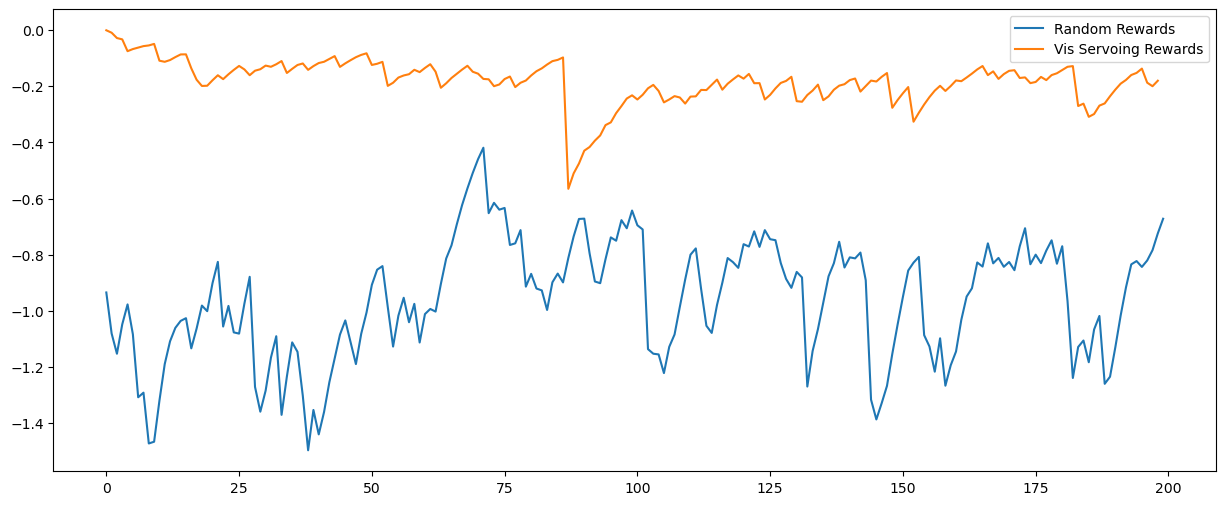

In [22]:
import pickle as pkl
rand_rews = np.array(pkl.load(open('./data/manip_data/vis_servoing/rand_rews.pkl', 'rb')))
vs_rews = np.array(pkl.load(open('./data/manip_data/vis_servoing/vs_rews.pkl', 'rb')))

plt.figure(figsize=(15, 6))
smoothing_factor = 0.9

# Calculate the smoothed rewards using a moving average
smoothed_rewards = [rand_rews[0]]
for r in rand_rews[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

plt.plot(smoothed_rewards, label='Random Rewards')

smoothed_rewards = [vs_rews[0]]
for r in vs_rews[1:]:
    smoothed_rewards.append(smoothed_rewards[-1] * smoothing_factor + r * (1 - smoothing_factor))

plt.plot(smoothed_rewards, label='Vis Servoing Rewards')
plt.legend()
# plt.ylim(-0.3, 0)
plt.show()

In [166]:
import cv2
import numpy as np

images = [np.random.randint(0, 256, (720, 1280, 3), dtype=np.uint8) for _ in range(200)]  # 10 random images

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change 'mp4v' to another codec

out = cv2.VideoWriter('delete_this.mp4', fourcc, 60.0, (1280, 720))
for image in images:
    out.write(image)

out.release()
print("Video saved successfully!")

Video saved successfully!


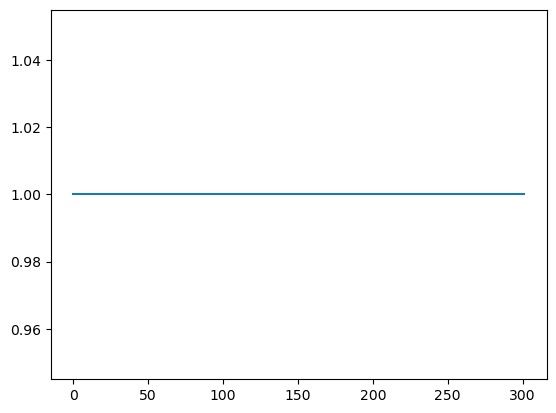

In [169]:
import numpy as np
horizon = 155
ep_len = 0
vid_frame = np.zeros(((horizon-4)*2, 2))

for t_step in range(500):
    t_step2 = t_step%horizon
    if ep_len == 0:
        if t_step2 == 0:
            continue
        elif t_step2 == 1:
            continue
        elif t_step2 == 2:
            continue
        elif t_step2 == horizon-1:
            ep_len = 1
        else:
            vid_frame[ep_len*(horizon-4) + t_step2-3] = np.array((t_step2-3, 1))
    else:
        if t_step2 == 0:
            continue
        elif t_step2 == 1:
            continue
        elif t_step2 == horizon-2:
            continue
        elif t_step2 == horizon-1:
            continue
        else:
            vid_frame[ep_len*(horizon-4) + t_step2-2] = np.array((ep_len*(horizon-4) + t_step2-2, 1))

plt.plot(vid_frame[:,0], vid_frame[:,1])

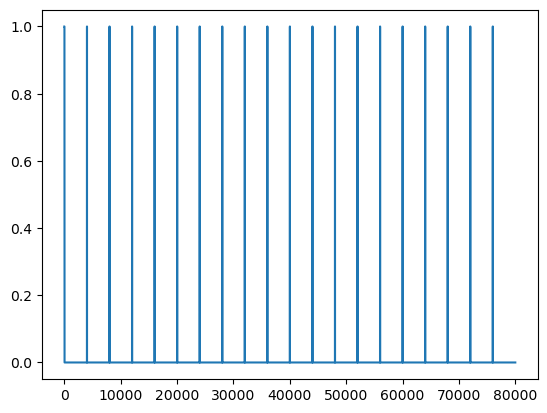

In [170]:
a = np.zeros(80000)
for i in range(80000):
    if i%4000 < 10:
        a[i] = 1
plt.plot(a)

In [171]:
import time
time.ctime()

'Sat Mar 30 15:59:00 2024'

: 

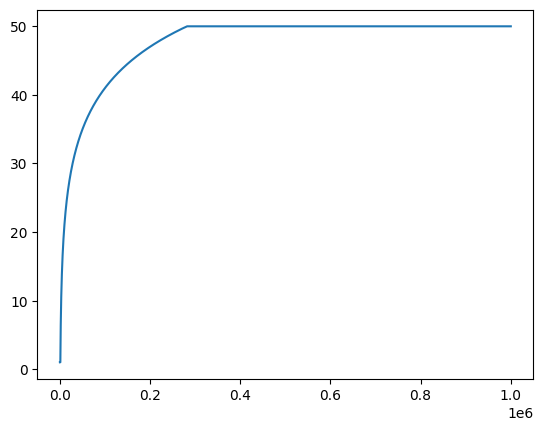

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def scale_epoch(x, A=100/np.log(100000), B=1/1000, C=1000):
    if x <= C:
        return 1
    else:
        return min(50, 1 + A * np.log(B * (x - C) + 1))

# Example usage
x_values = np.arange(0, 1000000)
y = [scale_epoch(x) for x in x_values]

plt.plot(x_values, y)

In [9]:
import torch
import torch.nn as nn
#  make a simple linear layer and pass a random tensor through it
linear_layer = nn.Linear(2, 5)
linear_layer.weight = nn.Parameter(torch.ones_like(linear_layer.weight))
input_tensor = torch.rand((2,10,2))
output = linear_layer(input_tensor)
output.shape

torch.Size([2, 10, 5])

(400, 8, 2)


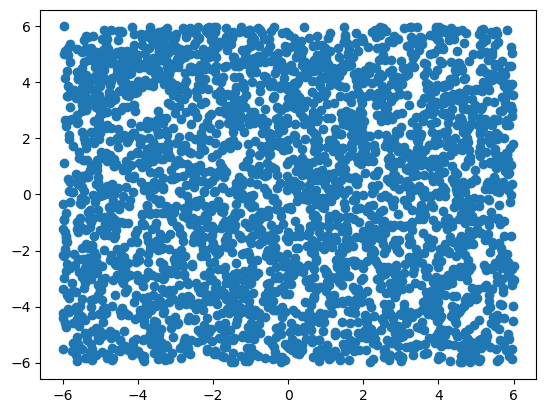

In [39]:
import numpy as np
x = np.random.uniform(-6, 6, (400,8,1))
y = np.random.uniform(-6, 6, (400,8,1))
sample = np.concatenate((x,y), axis=2)
print(sample.shape)
plt.scatter(sample[:, :, 0], sample[:, :, 1])

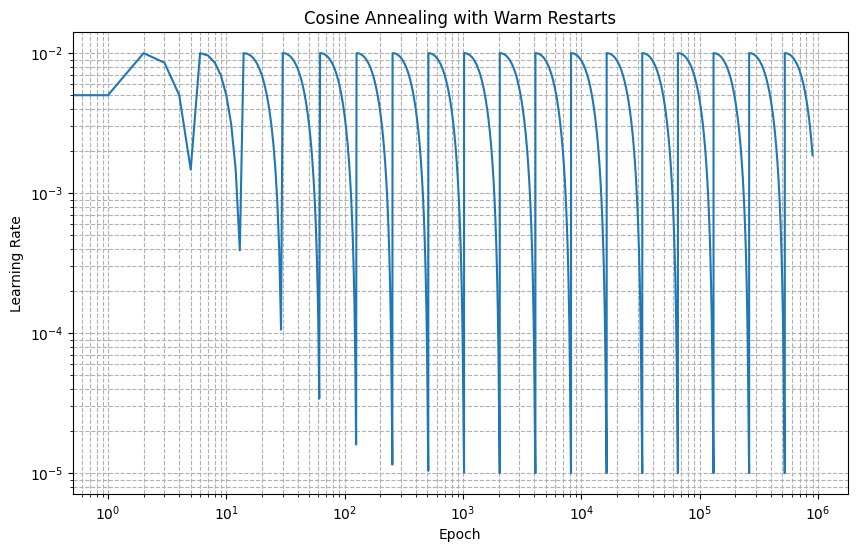

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Simulate the learning rate schedule
def simulate_cosine_annealing_warm_restarts(T_0=2, T_mult=2, eta_min=0.000001, eta_max=0.001, epochs=900000):
    # Dummy optimizer for the scheduler
    optimizer = torch.optim.Adam([torch.nn.Parameter(torch.randn(2, 2, requires_grad=True))], lr=1e-2)
    
    # CosineAnnealingWarmRestarts scheduler
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=2, eta_min=1e-5)
    
    lrs = []
    
    for epoch in range(epochs):
        scheduler.step(epoch)
        lr = scheduler.get_last_lr()[0]
        lrs.append(lr)
    
    return lrs

# Plot the learning rate schedule
def plot_learning_rates(lrs, epochs=900000):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(epochs), lrs)
    plt.title('Cosine Annealing with Warm Restarts')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')  # Log scale to better visualize changes over a large number of epochs
    plt.xscale('log')  # Log scale to better visualize changes over a large number of epochs
    plt.grid(True, which="both", ls="--")
    plt.show()

# Simulate and plot
lrs = simulate_cosine_annealing_warm_restarts(epochs=900000)
plot_learning_rates(lrs)


(2, 100)


/home/sarvesh/anaconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:988: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/home/sarvesh/anaconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


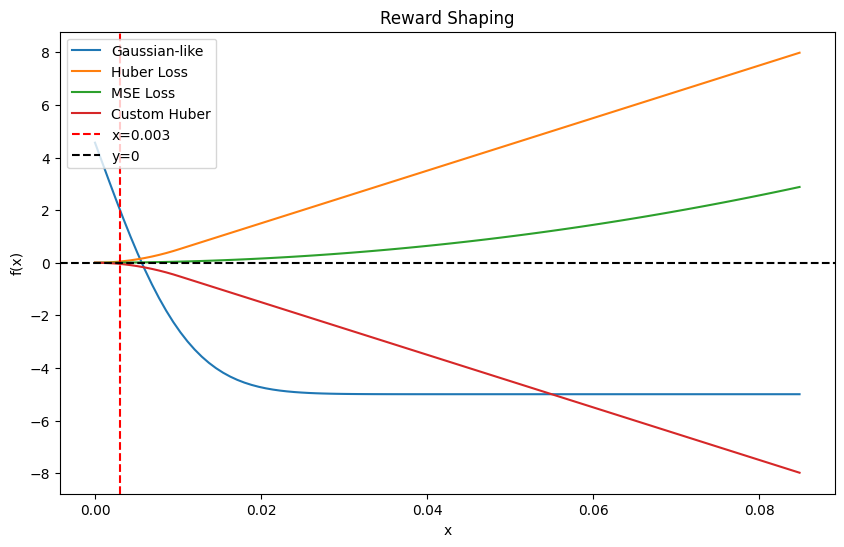

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import HuberLoss
from torch.nn import MSELoss

huber_loss = HuberLoss(delta=1)
mse_loss = MSELoss()

def huber_loss_custom(a):
    if a < 0.01:
        return -0.5  * (100*a)**2
    else:
        return -100*a + 0.5

def gaussian_like(x, a, b, c=0, d=0):
    return a * np.exp(-b * (x - c)**2) - d

# Parameters
a = 15  # Amplitude
b = 4500  # Width
c = -0.01    # Center
d = 5    # Vertical shift

u = np.linspace(0, 0.06, 100)
v = np.linspace(0, 0.06, 100)
x = np.vstack([u,v])
print(x.shape)
y1 = gaussian_like(np.linalg.norm(x, axis=0), a, b, c, d)
y2 = [huber_loss(torch.tensor(100*np.linalg.norm(x[:, i])), torch.tensor([0.0])).numpy() for i in range(100)]
y3 = [mse_loss(torch.tensor(20*np.linalg.norm(x[:, i])), torch.tensor([0.0])).numpy() for i in range(100)]
y4 = [huber_loss_custom(np.linalg.norm(x[:, i])) for i in range(100)]


plt.figure(figsize=(10, 6))
plt.plot(np.linalg.norm(x, axis=0), y1, label='Gaussian-like')
plt.plot(np.linalg.norm(x, axis=0), y2, label='Huber Loss')
plt.plot(np.linalg.norm(x, axis=0), y3, label='MSE Loss')
plt.plot(np.linalg.norm(x, axis=0), y4, label='Custom Huber')
plt.axvline(x=0.003, linestyle='--', color='r', label="x=0.003")  # Mark x=0.003
plt.axhline(y=0, linestyle='--', color='k', label="y=0")  # Mark y=0
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title("Reward Shaping")
plt.show()

In [60]:
infer_every = 4
for i in range(10):
    if (i%infer_every) < 2:
        print(i)

0
1
4
5
8
9


In [1]:
import numpy as np
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, KDTree
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

positions = [(pos[0] * 2000, pos[1] * 2000) for pos in kdtree_positions_world]

# Output the positions in a format suitable for the draw.io script
0.0375*2000, 0.043301*2000, 0.02165*2000, print(positions)

[(0.0, 0.0), (0.0, 86.602), (0.0, 173.204), (0.0, 259.806), (0.0, 346.408), (0.0, 433.01), (0.0, 519.612), (0.0, 606.214), (75.0, -43.3), (75.0, 43.302), (75.0, 129.904), (75.0, 216.50599999999997), (75.0, 303.108), (75.0, 389.71), (75.0, 476.31199999999995), (75.0, 562.914), (150.0, 0.0), (150.0, 86.602), (150.0, 173.204), (150.0, 259.806), (150.0, 346.408), (150.0, 433.01), (150.0, 519.612), (150.0, 606.214), (224.99999999999997, -43.3), (224.99999999999997, 43.302), (224.99999999999997, 129.904), (224.99999999999997, 216.50599999999997), (224.99999999999997, 303.108), (224.99999999999997, 389.71), (224.99999999999997, 476.31199999999995), (224.99999999999997, 562.914), (300.0, 0.0), (300.0, 86.602), (300.0, 173.204), (300.0, 259.806), (300.0, 346.408), (300.0, 433.01), (300.0, 519.612), (300.0, 606.214), (375.0, -43.3), (375.0, 43.302), (375.0, 129.904), (375.0, 216.50599999999997), (375.0, 303.108), (375.0, 389.71), (375.0, 476.31199999999995), (375.0, 562.914), (449.99999999999994

(75.0, 86.602, 43.3, None)

In [2]:
np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.     , -0.02165]), array([0.2625  , 0.303107]))

In [2]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(kdtree_positions_world[:,0], kdtree_positions_world[:,1])

# Set aspect ratio
ax.set_aspect('equal', 'box')

# Add grid
ax.grid(False)

# Set labels and title
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('8x8 Grid of Positions')

# Save the plot as a high-resolution image
plt.savefig('high_res_plot.svg', format='svg')

# Show the plot
plt.show()


NameError: name 'plt' is not defined

In [4]:
trajs = pkl.load(open('./data/test_trajs.pkl', 'rb'))
for name in trajs:
    pos = trajs[name]
    plt.plot(pos[:, 0], pos[:, 1], 'o', label=f'Curve Spline')
    plt.quiver(pos[:, 0], pos[:, 1], np.cos(pos[:, 2]), np.sin(pos[:, 2]))
    plt.legend()
    plt.show()

NameError: name 'pkl' is not defined

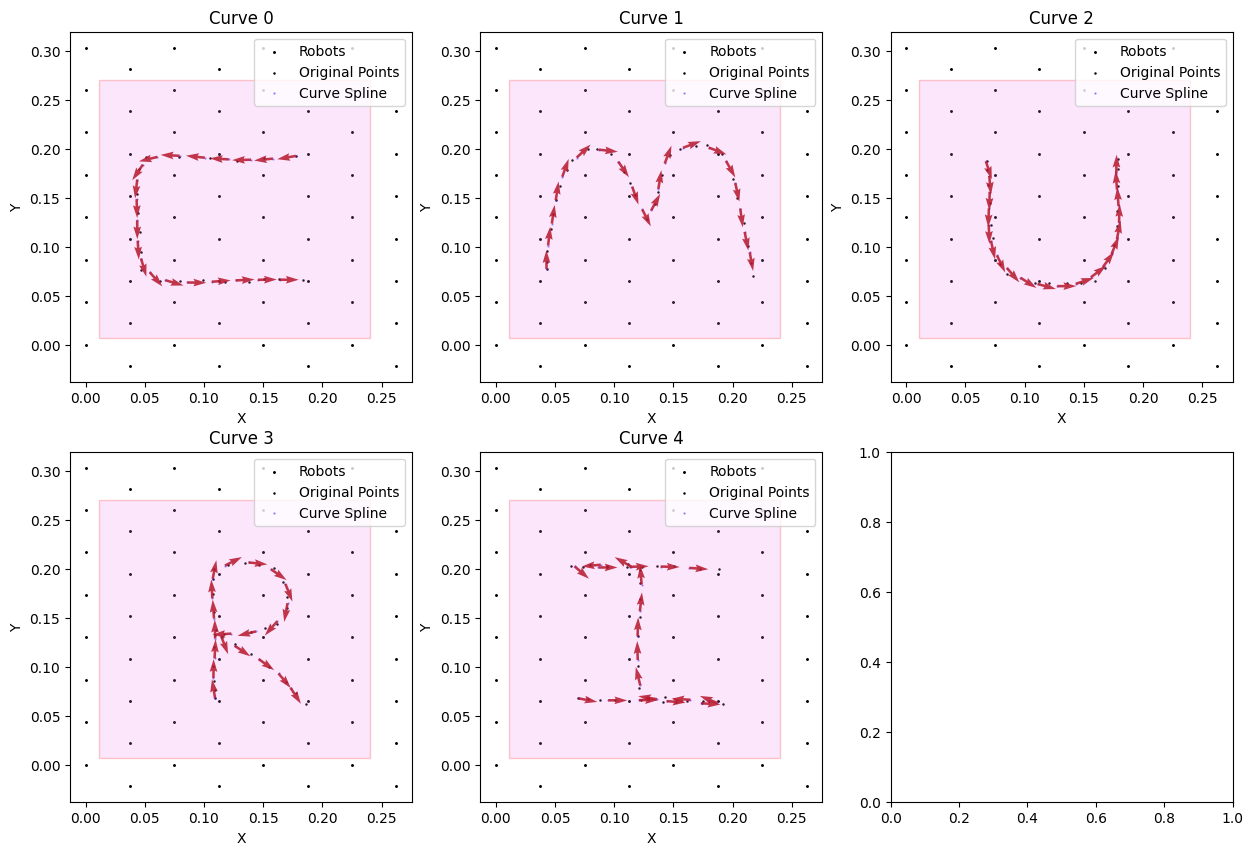

<Figure size 640x480 with 0 Axes>

In [21]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import splprep, splev

def fit_smooth_curve(points, s=0):
    x, y = zip(*points)
    tck, u = splprep([x, y], s=s)
    return tck, u

def evaluate_spline(tck, num_points=100):
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    dx = np.gradient(x_new)
    dy = np.gradient(y_new)
    theta = np.arctan2(dy, dx)
    # theta -= theta[0]
    return x_new, y_new, theta

def scale_points(points, scale_factor):
    center = np.mean(points, axis=0)
    centered_points = points - center
    scaled_points = centered_points * scale_factor
    
    result = scaled_points + center
    return result


data = pkl.load(open('./data/cmu_ri_pts.pkl', 'rb'))

new_data = {}
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

x0_0, x1 = 0.009, 0.19  # Lower-left corner
y0_0, y1 = 0.007, 0.23  # Upper-right corner
old_width = x1 - x0_0
old_height = y1 - y0_0

plane_size = np.array([(0.009, -0.376),(0.24200, 0.034)])
plane_size = np.array([(0.009, -0.376),(0.24200, 0.034)])

x0, x1 = 0.011, 0.24  # Lower-left corner
y0, y1 = 0.007, 0.27  # Upper-right corner
width = x1 - x0
height = y1 - y0

for n, name in enumerate(data):
    pts = np.array(data[name][0]).T[:, ::-1] #*np.array((-1, 1))
    
    # TODO: Undo this line for real world cos cam flipped
    pts[:,0] = np.max(pts[:,0]) - pts[:,0] + np.min(pts[:,0])
    
    # print(pts.shape)
    pts = scale_points(pts, 0.75)
    tck, _ = fit_smooth_curve(pts, s=0.0001)
    pos = np.array(evaluate_spline(tck, num_points=2000)).T
    xy = pts
    diff = np.roll(pos[:,2], -1) - pos[:,2]
    # print(np.rad2deg((diff + np.pi) % (2 * np.pi) - np.pi))
    pos = pos[np.arange(0, 2000, 100)]

    new_data[name] = pos
    ax = axes[n]
    ax.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], label='Robots', color="#000000", s=1.2)
    ax.scatter(pts[:, 0], pts[:, 1], label='Original Points', color="#000000", s=0.6)
    ax.scatter(pos[:, 0], pos[:, 1], label=f'Curve Spline', color="#0000ff55", s=0.6)
    ax.quiver(pos[:, 0], pos[:, 1], np.cos(pos[:, 2]), np.sin(pos[:, 2]), color="#aa0000dd")
    ax.legend()
    ax.set_title(f'Curve {n}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # old_rect = patches.Rectangle((x0_0, y0_0), old_width, old_height, linewidth=1, edgecolor='r', facecolor='yellow', alpha=0.2)
    rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='violet', alpha=0.2)
    # ax.add_patch(old_rect)
    ax.add_patch(rect)

# Set the limits of the plot to visualize the rectangle properly
# ax.set_xlim(0, max(x1 + 1, x0 + 1))
# ax.set_ylim(0, max(y1 + 1, y0 + 1))

# Display the plot
plt.show()
plt.tight_layout()
plt.show()
# pkl.dump(data, open("./data/cmu_ri_pts.pkl", "wb"))
pkl.dump(new_data, open("./data/cmu_ri.pkl", "wb"))

0 -179.657765950864
1 -164.65885103149648
2 -0.6143498914219324
3 77.3769667281476
4 -167.93607690179152
5 -57.440507973582555


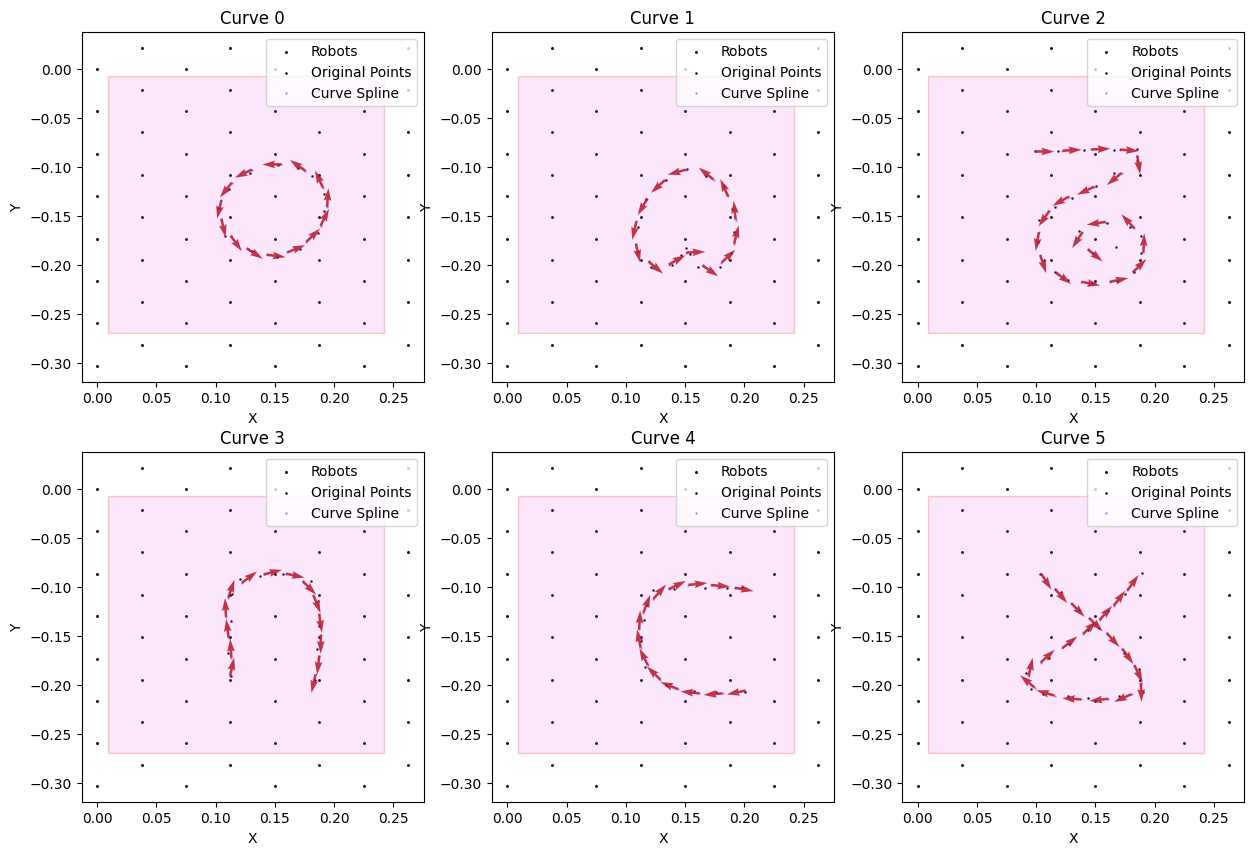

<Figure size 640x480 with 0 Axes>

In [14]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.interpolate import splprep, splev

rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, -j*0.043301 + 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, -j*0.043301 + 0.02165))
        else:
            finger_pos = np.array((i*0.0375, -j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, -j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

positions = [(pos[0] * 2000, pos[1] * 2000) for pos in kdtree_positions_world]

def fit_smooth_curve(points, s=0):
    x, y = zip(*points)
    tck, u = splprep([x, y], s=s)
    return tck, u

def evaluate_spline(tck, num_points=100):
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    dx = np.gradient(x_new)
    dy = np.gradient(y_new)
    theta = np.arctan2(dy, dx)
    # theta -= theta[0]
    return x_new, y_new, theta

def scale_points(points, scale_factor):
    center = np.mean(points, axis=0)
    centered_points = points - center
    scaled_points = centered_points * scale_factor
    
    result = scaled_points + center
    return result


data = pkl.load(open('./data/test_pts.pkl', 'rb'))

new_data = {}
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plane_size = np.array([(0.009, -0.376),(0.24200, 0.034)])

x0, x1 = 0.009, 0.242    # Lower-left corner
y0, y1 = -0.27, -0.007   # Upper-right corner
width = x1 - x0
height = y1 - y0

for n, name in enumerate(data):
    pts = np.array(data[name][0]).T*np.array((1, -1)) #[:, ::-1] #
    
    # TODO: Undo this line for real world cos cam flipped
    # pts[:,0] = np.max(pts[:,0]) - pts[:,0] + np.min(pts[:,0])
    
    # print(pts.shape)
    # pts = scale_points(pts, 0.75)
    tck, _ = fit_smooth_curve(pts, s=0.0001)
    pos = np.array(evaluate_spline(tck, num_points=2000)).T
    xy = pts
    diff = np.roll(pos[:,2], -1) - pos[:,2]
    # print(np.rad2deg((diff + np.pi) % (2 * np.pi) - np.pi))
    
    if n in [0, 1, 3, 4]:
        pos = pos[np.arange(0, 2000, 150)]
    else:
        pos = pos[np.arange(0, 2000, 100)]

    new_data[name] = pos
    ax = axes[n]
    ax.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], label='Robots', color="#000000", s=1.2)
    ax.scatter(pts[:, 0], pts[:, 1], label='Original Points', color="#000000", s=0.6)
    ax.scatter(pos[:, 0], pos[:, 1], label=f'Curve Spline', color="#0000ff55", s=0.6)
        
    print(n, pos[0, 2]*180/np.pi)
    ax.quiver(pos[:, 0], pos[:, 1], np.cos(pos[:, 2]), np.sin(pos[:, 2]), color="#aa0000dd")
    ax.legend()
    ax.set_title(f'Curve {n}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # old_rect = patches.Rectangle((x0_0, y0_0), old_width, old_height, linewidth=1, edgecolor='r', facecolor='yellow', alpha=0.2)
    rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor='r', facecolor='violet', alpha=0.2)
    # ax.add_patch(old_rect)
    ax.add_patch(rect)

# Set the limits of the plot to visualize the rectangle properly
# ax.set_xlim(0, max(x1 + 1, x0 + 1))
# ax.set_ylim(0, max(y1 + 1, y0 + 1))

# Display the plot
plt.show()
plt.tight_layout()
plt.show()
# pkl.dump(data, open("./data/cmu_ri_pts.pkl", "wb"))
pkl.dump(new_data, open("./data/test_trajs_real.pkl", "wb"))

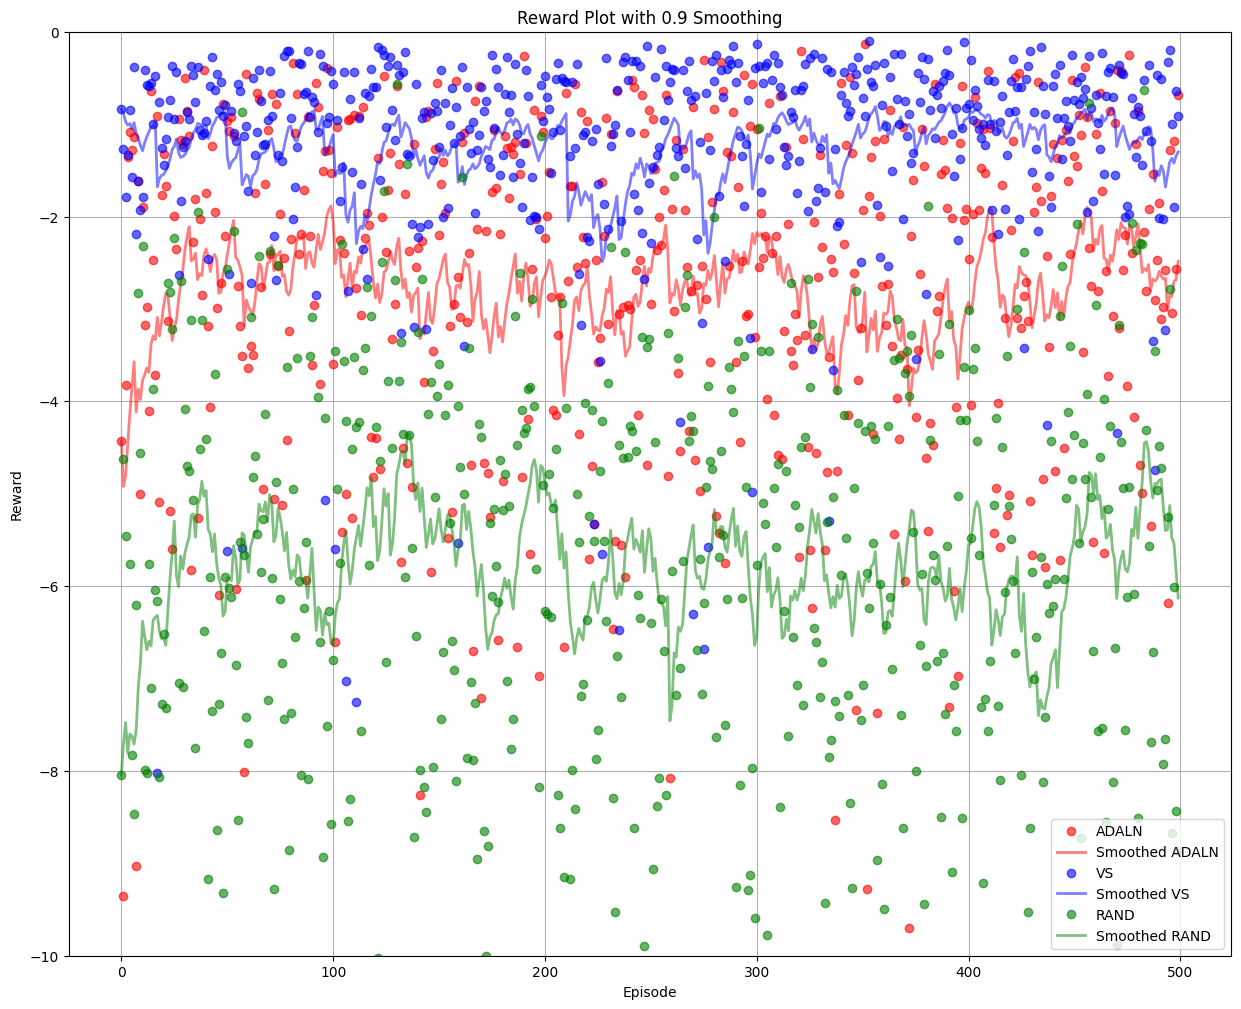

In [22]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

data = pkl.load(open("./rew_comparison.pkl", "rb"))
adaln = data['MATSAC_ADALN']
vs = data['VS']
rand = data['RAND']

# smooth the data and plot
smoothing_factor = 0.9

# Calculate the smoothed rewards using a moving average
smoothed_adaln = [adaln[0]]
smoothed_vs = [vs[0]]
smoothed_rand = [rand[0]]
for r in adaln[1:]:
    smoothed_adaln.append(smoothed_adaln[-1] * smoothing_factor + r * (1 - smoothing_factor))
for r in vs[1:]:
    smoothed_vs.append(smoothed_vs[-1] * smoothing_factor + r * (1 - smoothing_factor))
for r in rand[1:]:
    smoothed_rand.append(smoothed_rand[-1] * smoothing_factor + r * (1 - smoothing_factor))
    
# Create a figure and plot the rewards and smoothed rewards
plt.figure(figsize=(15, 12))
plt.plot(adaln, "ro", label='ADALN', alpha=0.6)
plt.plot(smoothed_adaln, label='Smoothed ADALN', color='red', linewidth=2, alpha=0.5)
plt.plot(vs, "bo", label='VS', alpha=0.6)
plt.plot(smoothed_vs, label='Smoothed VS', color='blue', linewidth=2, alpha=0.5)
plt.plot(rand, "go", label='RAND', alpha=0.6)
plt.plot(smoothed_rand, label='Smoothed RAND', color='green', linewidth=2, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward Plot with 0.9 Smoothing')
plt.legend()
plt.ylim(-10, 0)
plt.grid(True)
plt.show()

/tmp/ipykernel_20004/2037660314.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_box.set_yticklabels(['ADALN', 'VS', 'RAND'])


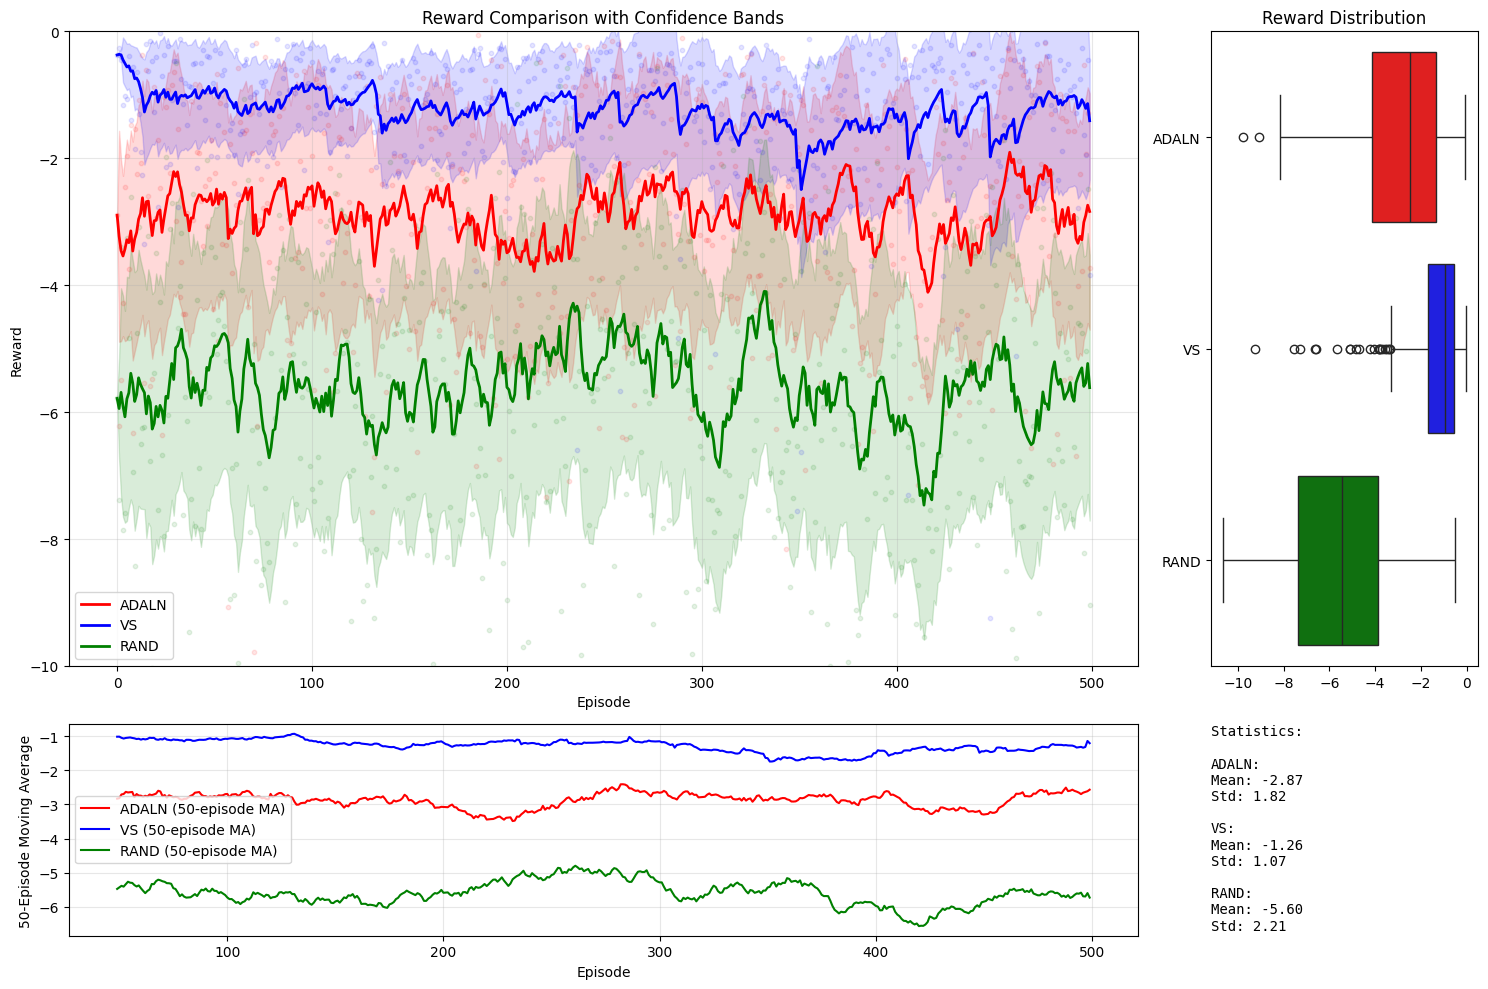

/tmp/ipykernel_20004/2037660314.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_box.set_yticklabels(['ADALN', 'VS', 'RAND'])


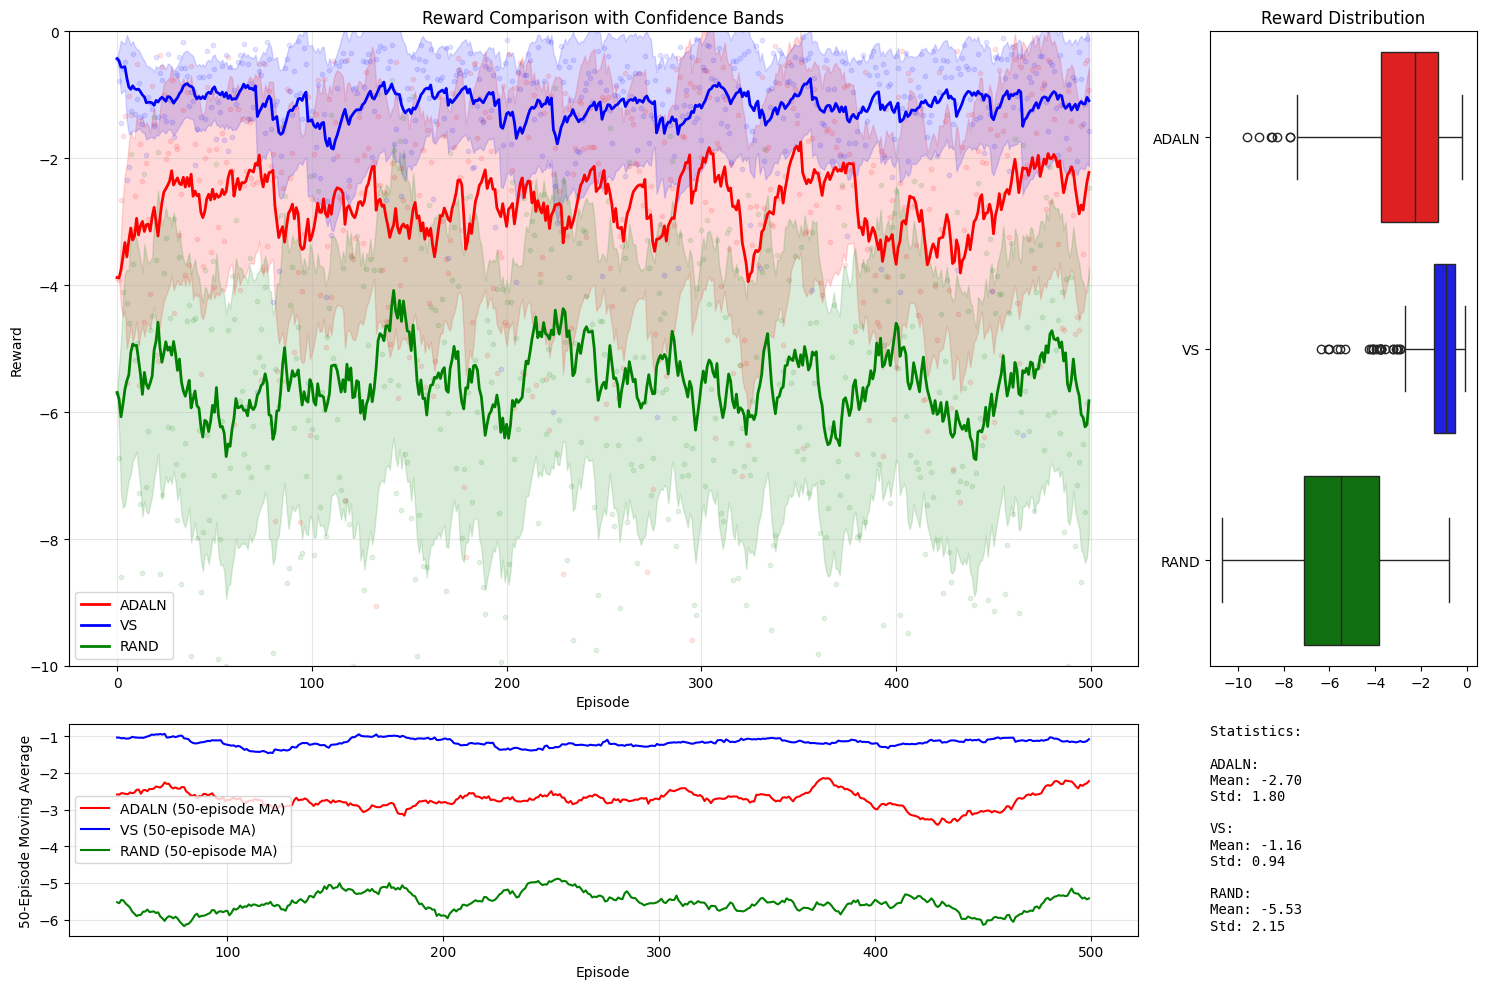

/tmp/ipykernel_20004/2037660314.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_box.set_yticklabels(['ADALN', 'VS', 'RAND'])


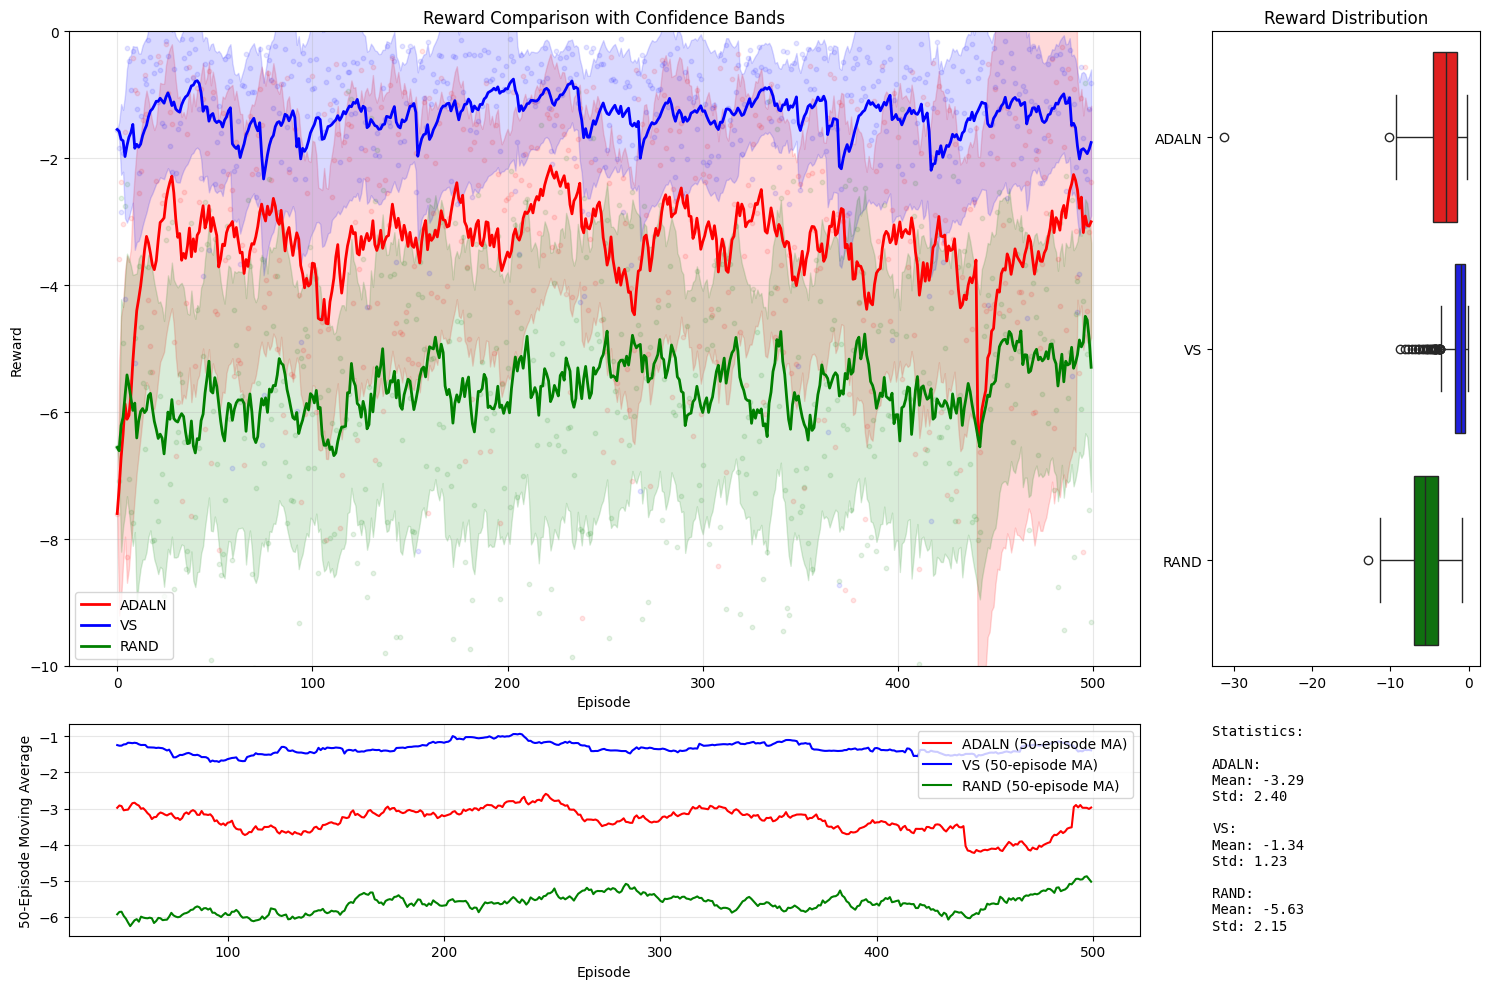

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_rewards_comparison(adaln, vs, rand, smoothing_factor=0.9):
    # Calculate smoothed values
    def smooth_data(data):
        smoothed = [data[0]]
        for r in data[1:]:
            smoothed.append(smoothed[-1] * smoothing_factor + r * (1 - smoothing_factor))
        return np.array(smoothed)
    
    smoothed_adaln = smooth_data(adaln)
    smoothed_vs = smooth_data(vs)
    smoothed_rand = smooth_data(rand)
    
    # Calculate rolling standard deviation (for confidence bands)
    window = 50
    def rolling_std(data):
        return np.array([np.std(data[max(0, i-window):i+1]) 
                        for i in range(len(data))])
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[4, 1])
    
    # Main plot
    ax_main = fig.add_subplot(gs[0, 0])
    
    # Plot smoothed lines
    episodes = np.arange(len(adaln))
    ax_main.plot(episodes, smoothed_adaln, 'r-', label='ADALN', linewidth=2)
    ax_main.plot(episodes, smoothed_vs, 'b-', label='VS', linewidth=2)
    ax_main.plot(episodes, smoothed_rand, 'g-', label='RAND', linewidth=2)
    ax_main.set_ylim(-10, 0)
    
    # Add confidence bands
    alpha = 0.15
    std_adaln = rolling_std(adaln)
    std_vs = rolling_std(vs)
    std_rand = rolling_std(rand)
    
    ax_main.fill_between(episodes, smoothed_adaln-std_adaln, smoothed_adaln+std_adaln, 
                        color='red', alpha=alpha)
    ax_main.fill_between(episodes, smoothed_vs-std_vs, smoothed_vs+std_vs, 
                        color='blue', alpha=alpha)
    ax_main.fill_between(episodes, smoothed_rand-std_rand, smoothed_rand+std_rand, 
                        color='green', alpha=alpha)
    
    # Scatter plot with reduced alpha and size
    ax_main.scatter(episodes, adaln, color='red', alpha=0.1, s=10)
    ax_main.scatter(episodes, vs, color='blue', alpha=0.1, s=10)
    ax_main.scatter(episodes, rand, color='green', alpha=0.1, s=10)
    
    # Main plot styling
    ax_main.set_xlabel('Episode')
    ax_main.set_ylabel('Reward')
    ax_main.set_title('Reward Comparison with Confidence Bands')
    ax_main.grid(True, alpha=0.3)
    ax_main.legend()
    
    # Box plot on the right
    ax_box = fig.add_subplot(gs[0, 1])
    box_data = [adaln, vs, rand]
    sns.boxplot(data=box_data, orient='h', ax=ax_box, 
                palette=['red', 'blue', 'green'])
    ax_box.set_yticklabels(['ADALN', 'VS', 'RAND'])
    ax_box.set_title('Reward Distribution')
    
    # Moving average plot at the bottom
    ax_ma = fig.add_subplot(gs[1, 0])
    window_size = 50
    def moving_average(data, window):
        return np.convolve(data, np.ones(window)/window, mode='valid')
    
    ma_episodes = np.arange(len(adaln))[window_size-1:]
    ax_ma.plot(ma_episodes, moving_average(adaln, window_size), 'r-', 
               label=f'ADALN ({window_size}-episode MA)')
    ax_ma.plot(ma_episodes, moving_average(vs, window_size), 'b-', 
               label=f'VS ({window_size}-episode MA)')
    ax_ma.plot(ma_episodes, moving_average(rand, window_size), 'g-', 
               label=f'RAND ({window_size}-episode MA)')
    
    ax_ma.set_xlabel('Episode')
    ax_ma.set_ylabel(f'{window_size}-Episode Moving Average')
    ax_ma.grid(True, alpha=0.3)
    ax_ma.legend()
    
    # Add statistics table
    ax_stats = fig.add_subplot(gs[1, 1])
    ax_stats.axis('off')
    stats_text = (
        'Statistics:\n\n'
        f'ADALN:\n'
        f'Mean: {np.mean(adaln):.2f}\n'
        f'Std: {np.std(adaln):.2f}\n\n'
        f'VS:\n'
        f'Mean: {np.mean(vs):.2f}\n'
        f'Std: {np.std(vs):.2f}\n\n'
        f'RAND:\n'
        f'Mean: {np.mean(rand):.2f}\n'
        f'Std: {np.std(rand):.2f}'
    )
    ax_stats.text(0, 1, stats_text, va='top', fontfamily='monospace')
    
    plt.tight_layout()
    return fig

data = pkl.load(open("./data/comparison/rew_comparison.pkl", "rb"))
adaln = data['MATSAC_ADALN']
vs = data['VS']
rand = data['RAND']

# Create and show the plot
fig = plot_rewards_comparison(adaln, vs, rand)
plt.show()

data = pkl.load(open("./data/comparison/rew_comparison_no_clone.pkl", "rb"))
adaln = data['MATSAC_ADALN']
vs = data['VS']
rand = data['RAND']

# Create and show the plot
fig = plot_rewards_comparison(adaln, vs, rand)
plt.show()

data = pkl.load(open("./data/comparison/rew_comparison_gauss.pkl", "rb"))
adaln = data['MATSAC_ADALN']
vs = data['VS']
rand = data['RAND']

# Create and show the plot
fig = plot_rewards_comparison(adaln, vs, rand)
plt.show()

In [19]:
import cv2

def flip_and_rotate_video(input_video_path, output_video_path, flip_direction=None, rotation_angle=0):
    """
    Reads a video file, flips and/or rotates each frame as specified, and writes the result to a new video file.

    Parameters:
    - input_video_path: Path to the input video file.
    - output_video_path: Path where the output video will be saved.
    - flip_direction: 'horizontal', 'vertical', or None for no flipping.
    - rotation_angle: Rotation angle in degrees. Supports 90, -90, or 0 (no rotation).
    """
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error: Could not open input video.")
        return

    # Retrieve video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Check if FPS value is valid
    if fps == 0 or fps is None:
        fps = 30  # Default to 30 FPS if unable to get from the video

    # Determine rotation flag and adjust frame dimensions
    rotation_flag = None
    if rotation_angle == 90:
        rotation_flag = cv2.ROTATE_90_CLOCKWISE
        output_frame_width = frame_height
        output_frame_height = frame_width
    elif rotation_angle == -90:
        rotation_flag = cv2.ROTATE_90_COUNTERCLOCKWISE
        output_frame_width = frame_height
        output_frame_height = frame_width
    elif rotation_angle == 0:
        rotation_flag = None
        output_frame_width = frame_width
        output_frame_height = frame_height
    else:
        print("Error: rotation_angle must be 0, 90, or -90 degrees.")
        cap.release()
        return

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change codec as needed
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_frame_width, output_frame_height))

    # Determine the flip code based on flip_direction
    if flip_direction is not None:
        if flip_direction.lower() == 'horizontal':
            flip_code = 1  # Horizontal flip
        elif flip_direction.lower() == 'vertical':
            flip_code = 0  # Vertical flip
        else:
            print("Error: flip_direction must be 'horizontal', 'vertical', or None.")
            cap.release()
            out.release()
            return
    else:
        flip_code = None  # No flip

    print("Processing video...")

    while True:
        ret, frame = cap.read()

        if not ret:
            break  # Exit loop if no frames are left to read

        # Flip the frame if flip_code is set
        if flip_code is not None:
            frame = cv2.flip(frame, flip_code)

        # Rotate the frame if rotation_flag is set
        if rotation_flag is not None:
            frame = cv2.rotate(frame, rotation_flag)

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()

    print(f"Video processing complete. Processed video saved to '{output_video_path}'.")

id = 4
input_path = f"./data/videos/madp_new_data/cmuri_MADP_8_{id}.avi"       # Replace with your input video file path
output_path = f"./data/videos/madp_new_data/cmuri_MADP_8_{id}_0.avi"     # Replace with your desired output file path
flip_type = "vertical"
rotation = 90

flip_and_rotate_video(input_path, output_path, flip_type, rotation)

Processing video...
Video processing complete. Processed video saved to './data/videos/madp_new_data/cmuri_MADP_8_4_0.avi'.


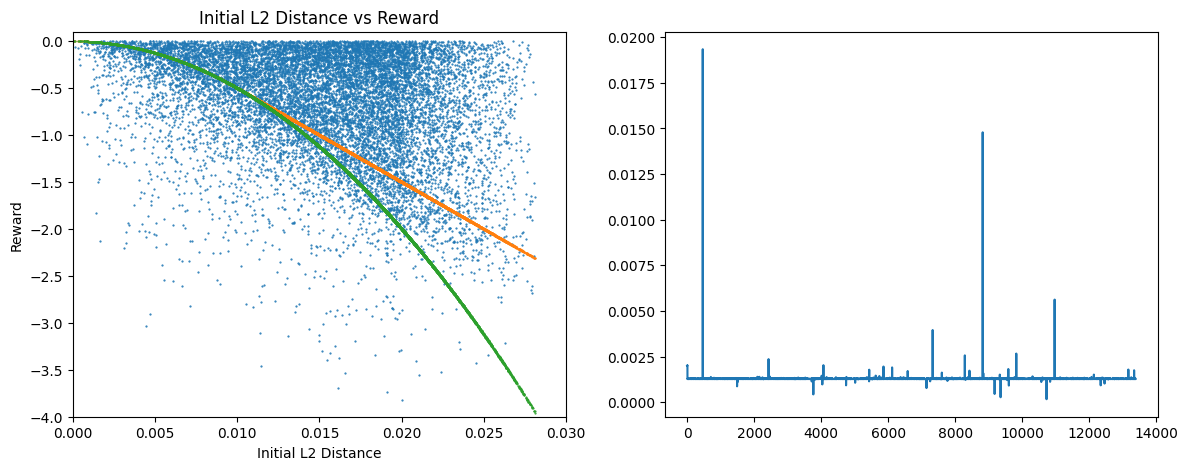

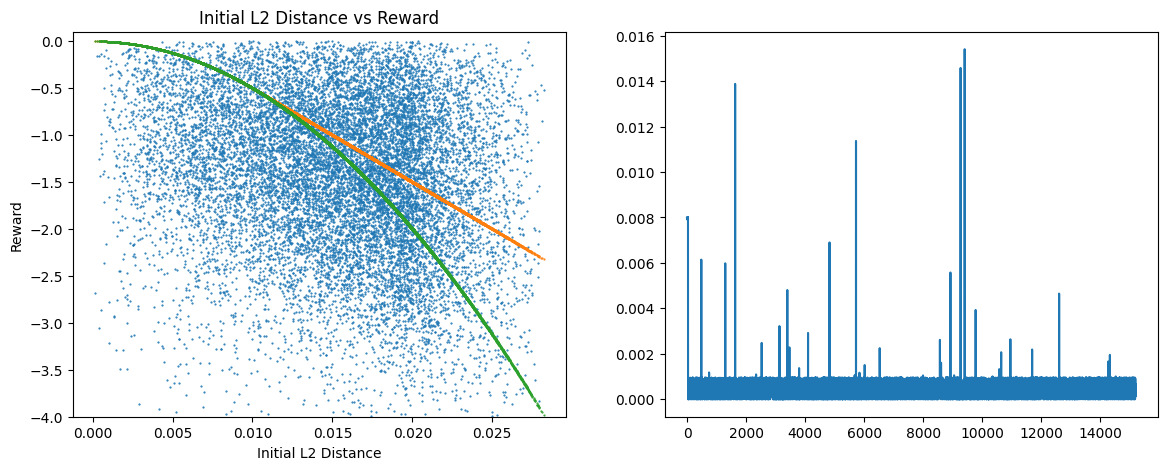

In [67]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

dic1 = pkl.load(open('./init_vs_reward.pkl', 'rb'))
dic2 = pkl.load(open('./init_vs_reward_diff_policy.pkl', 'rb'))
# dic3 = pkl.load(open('./init_vs_reward_withoutcawr.pkl', 'rb'))

def print_inference_stats(dic, loss2=False):
    # x_axis = np.linspace(0, 0.06, 1000)
    x_axis1 = np.array(dic['initial_l2_dist'])
    x_axis=[]
    # losses = 5*x_axis1 if loss2 else 100*x_axis1
    losses = 100*x_axis1
    rew_nominal = []
    euclidean_dist = []
    for n, loss in enumerate(losses):
        if dic['z_dist'][n]>0.0025:
            continue
        x_axis.append(x_axis1[n])
        euclidean_dist.append(-0.5  * loss**2)
        if loss < 1:
            rew_nominal.append(-0.5  * loss**2)
        else:
            rew_nominal.append(-loss + 0.5)

    # print(rew_nominal)
    # make 2 subplots 
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].scatter(dic['initial_l2_dist'], dic['reward'], s=0.3)
    ax[0].scatter(x_axis, rew_nominal, s=0.3)
    ax[0].scatter(x_axis, euclidean_dist, s=0.3)
    ax[0].set_title('Initial L2 Distance vs Reward')
    ax[0].set_xlabel('Initial L2 Distance')
    ax[0].set_ylabel('Reward')
    if loss2:
        # ax[0].set_xlim(0, 0.65)
        pass
    else:
        ax[0].set_xlim(0, 0.03)
    ax[0].set_ylim(-4, 0.1)
    ax[1].plot(dic['z_dist'])
    plt.show()

print_inference_stats(dic1)
print_inference_stats(dic2, loss2=True)
# print_inference_stats(dic3)

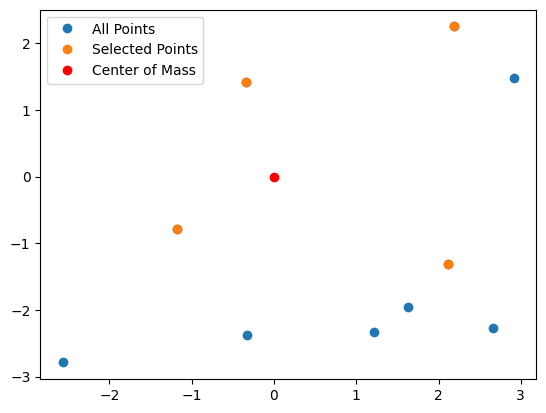

In [65]:
def select_one_point_per_quadrant(points, com):
    # Calculate points relative to the center of mass (COM)
    relative_points = points - com
    relative_points = np.sign(relative_points)

    quadrants = np.zeros(points.shape[0], dtype=int)
    quadrants[(relative_points[:,0] >= 0) & (relative_points[:,1] > 0)] = 1  # Quadrant I
    quadrants[(relative_points[:,0] < 0) & (relative_points[:,1] >= 0)] = 2  # Quadrant II
    quadrants[(relative_points[:,0] <= 0) & (relative_points[:,1] < 0)] = 3  # Quadrant III
    quadrants[(relative_points[:,0] > 0) & (relative_points[:,1] <= 0)] = 4  # Quadrant IV

    # Initialize an array to store the index of one point per quadrant
    selected_points = []

    # Loop over each quadrant to find one point to keep
    for i in range(1, 5):
        # Find indices of points in the current quadrant
        in_quadrant = np.where(quadrants == i)[0]
        if in_quadrant.size > 0:
            # Optionally, select the point closest to the COM within this quadrant
            distances = np.linalg.norm(relative_points[in_quadrant], axis=1)
            # Select the index of the point with the minimum distance
            min_index = in_quadrant[np.argmin(distances)]
            selected_points.append(points[min_index])

    # Return the selected points as a NumPy array
    return np.array(selected_points)

# Example usage
points = np.random.uniform(-3, 3, (10, 2))  # Random points
com = np.array([0, 0])  # Center of mass (x, y)

selected_points = select_one_point_per_quadrant(points, com)
plt.plot(points[:, 0], points[:, 1], 'o', label='All Points')
plt.plot(selected_points[:, 0], selected_points[:, 1], 'o', label='Selected Points')
plt.plot(com[0], com[1], 'ro', label='Center of Mass')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.legend()
plt.show()

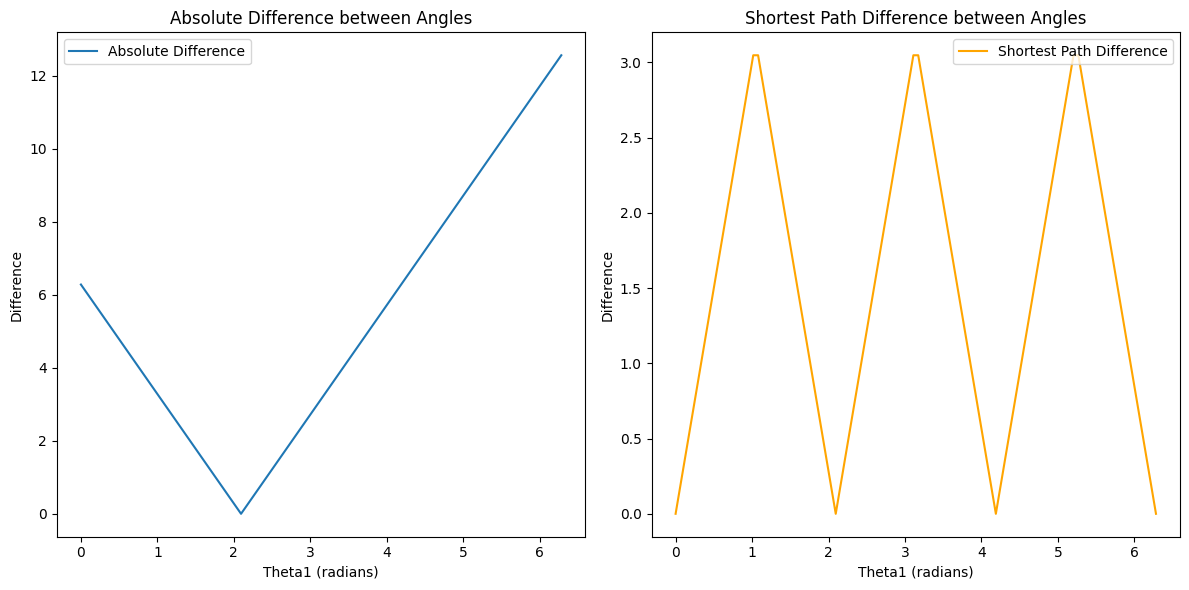

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_angle(angle):
    """ Normalize angle to the range [0, 2*pi) """
    return angle % (2 * np.pi)

def angle_difference(theta1, theta2):
    """ Calculate the shortest path difference between two angles """
    delta_theta = theta1 - theta2
    delta_theta = (delta_theta + np.pi) % (2 * np.pi) - np.pi
    return np.abs(delta_theta)

# Simulated data
num_points = 100
theta1 = np.linspace(0, 2 * np.pi, num_points)
theta2 = np.linspace(-2 * np.pi, 2 * np.pi, num_points)[::-1]  # Reverse the array for variation

# Calculate differences
abs_diff = np.abs(theta1 - theta2)
shortest_path_diff = [angle_difference(t1, t2) for t1, t2 in zip(theta1, theta2)]

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(theta1, abs_diff, label='Absolute Difference')
plt.xlabel('Theta1 (radians)')
plt.ylabel('Difference')
plt.title('Absolute Difference between Angles')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(theta1, shortest_path_diff, label='Shortest Path Difference', color='orange')
plt.xlabel('Theta1 (radians)')
plt.ylabel('Difference')
plt.title('Shortest Path Difference between Angles')
plt.legend()

plt.tight_layout()
plt.show()